# **Comprehensive Relationship Analysis: Mathematical Foundations & Practical Applications**

## **Overview**

This notebook provides an in-depth exploration of relationship analysis techniques, covering both the mathematical foundations and practical interpretations. We'll analyze relationships between:

1. **Categorical-Categorical Variables** (limited in our dataset)
2. **Categorical-Numerical Variables** (Gender vs Age, Income, Spending Score)

Each test will be explained with:
- **Mathematical formulation** with detailed explanations of each component
- **Intuitive understanding** of why the test works
- **Practical interpretation** in the context of our Mall_Customers dataset
- **Assumptions and limitations**

## **Dataset Context**
- **Gender**: Categorical (Male/Female)
- **Age**: Numerical (continuous)
- **Annual Income (k$)**: Numerical (continuous) 
- **Spending Score (1-100)**: Numerical (discrete but treated as continuous)


In [6]:
# Setup and Data Loading
%store -r

print("Project configuration:")
print(f"SLUG = {SLUG}")
print(f"DATA_DIR = {DATA_DIR}")
print(f"DATASET_KEY = {DATASET_KEY}")

# Set default values if variables are not found
if 'SLUG' not in globals() or not SLUG:
    SLUG = 'customer-segmentation'
    DATASET_KEY = 'vjchoudhary7/customer-segmentation-tutorial-in-python'
    GIT_ROOT = Path.cwd().parent.parent.parent.parent
    DATA_DIR = GIT_ROOT / 'data' / SLUG
    FIG_DIR = GIT_ROOT / 'figures' / SLUG
    REP_DIR = GIT_ROOT / 'reports' / SLUG
    NOTEBOOK_DIR = GIT_ROOT / 'notebooks' / SLUG

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, kruskal, mannwhitneyu
from scipy.stats import pearsonr, spearmanr
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load dataset
df = pd.read_csv(DATA_DIR / 'Mall_Customers.csv')
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Project configuration:
SLUG = customer-segmentation
DATA_DIR = /Users/ravisharma/workdir/eda_practice/data/customer-segmentation
DATASET_KEY = vjchoudhary7/customer-segmentation-tutorial-in-python

Dataset shape: (200, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First few rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# **PART I: CATEGORICAL-NUMERICAL RELATIONSHIPS**

## **1. Independent Samples t-Test**

### **Mathematical Foundation**

The independent samples t-test compares means between two groups. For our Gender vs numerical variables:

**Test Statistic:**
$$t = \frac{\bar{X}_1 - \bar{X}_2}{s_p \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

Where:
- $\bar{X}_1, \bar{X}_2$: Sample means for groups 1 and 2
- $s_p$: Pooled standard deviation = $\sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}}$
- $n_1, n_2$: Sample sizes for groups 1 and 2
- $s_1^2, s_2^2$: Sample variances for groups 1 and 2

**Degrees of Freedom:** $df = n_1 + n_2 - 2$

### **Why It Works**
- **Numerator**: Measures the actual difference between group means
- **Denominator**: Standardizes by the expected variability under null hypothesis
- **Pooled variance**: Combines information from both groups, assuming equal variances
- **Square root term**: Accounts for sample size differences

### **Assumptions**
1. **Independence**: Observations within and between groups are independent
2. **Normality**: Data in each group follows normal distribution
3. **Homoscedasticity**: Equal variances between groups ($\sigma_1^2 = \sigma_2^2$)

### **Interpretation**
- **Large |t|**: Greater evidence against null hypothesis (no difference in means)
- **p-value < α**: Reject null hypothesis, conclude significant difference exists
- **Effect size (Cohen's d)**: $d = \frac{\bar{X}_1 - \bar{X}_2}{s_p}$ measures practical significance


In [2]:
# Implementation: t-Test for Gender vs Numerical Variables

def perform_ttest_analysis(df, categorical_col, numerical_col):
    """
    Perform comprehensive t-test analysis with effect size calculation
    """
    # Get groups
    groups = df[categorical_col].unique()
    group1_data = df[df[categorical_col] == groups[0]][numerical_col]
    group2_data = df[df[categorical_col] == groups[1]][numerical_col]
    
    # Basic statistics
    n1, n2 = len(group1_data), len(group2_data)
    mean1, mean2 = group1_data.mean(), group2_data.mean()
    std1, std2 = group1_data.std(), group2_data.std()
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
    
    # Effect size (Cohen's d)
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    
    # Test for equal variances (Levene's test)
    levene_stat, levene_p = stats.levene(group1_data, group2_data)
    
    print(f"=== t-Test Analysis: {categorical_col} vs {numerical_col} ===")
    print(f"\nGroup Statistics:")
    print(f"{groups[0]}: n={n1}, mean={mean1:.2f}, std={std1:.2f}")
    print(f"{groups[1]}: n={n2}, mean={mean2:.2f}, std={std2:.2f}")
    
    print(f"\nTest Results:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Cohen's d (effect size): {cohens_d:.4f}")
    
    print(f"\nAssumption Checks:")
    print(f"Levene's test for equal variances: p = {levene_p:.6f}")
    print(f"Equal variances assumption: {'Met' if levene_p > 0.05 else 'Violated'}")
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"\nInterpretation:")
    print(f"Effect size: {effect_size}")
    if p_value < 0.05:
        print(f"Significant difference detected (p < 0.05)")
        print(f"The difference of {abs(mean1-mean2):.2f} units is statistically significant")
    else:
        print(f"No significant difference detected (p ≥ 0.05)")
    
    return {
        'groups': groups,
        'means': [mean1, mean2],
        'stds': [std1, std2],
        't_stat': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'effect_size': effect_size
    }

# Test all numerical variables against Gender
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

results = {}
for col in numerical_cols:
    results[col] = perform_ttest_analysis(df, 'Gender', col)
    print("\n" + "="*80 + "\n")


=== t-Test Analysis: Gender vs Age ===

Group Statistics:
Male: n=88, mean=39.81, std=15.51
Female: n=112, mean=38.10, std=12.64

Test Results:
t-statistic: 0.8581
p-value: 0.391891
Cohen's d (effect size): 0.1222

Assumption Checks:
Levene's test for equal variances: p = 0.037281
Equal variances assumption: Violated

Interpretation:
Effect size: negligible
No significant difference detected (p ≥ 0.05)


=== t-Test Analysis: Gender vs Annual Income (k$) ===

Group Statistics:
Male: n=88, mean=62.23, std=26.64
Female: n=112, mean=59.25, std=26.01

Test Results:
t-statistic: 0.7950
p-value: 0.427552
Cohen's d (effect size): 0.1133

Assumption Checks:
Levene's test for equal variances: p = 0.922933
Equal variances assumption: Met

Interpretation:
Effect size: negligible
No significant difference detected (p ≥ 0.05)


=== t-Test Analysis: Gender vs Spending Score (1-100) ===

Group Statistics:
Male: n=88, mean=48.51, std=27.90
Female: n=112, mean=51.53, std=24.11

Test Results:
t-statistic

## **2. Mann-Whitney U Test (Wilcoxon Rank-Sum Test)**

### **Mathematical Foundation**

The Mann-Whitney U test is the non-parametric alternative to the t-test, comparing distributions rather than means.

**Test Statistic:**
$$U_1 = R_1 - \frac{n_1(n_1+1)}{2}$$
$$U_2 = R_2 - \frac{n_2(n_2+1)}{2}$$

Where:
- $R_1, R_2$: Sum of ranks for groups 1 and 2
- $n_1, n_2$: Sample sizes
- $U = \min(U_1, U_2)$ is the test statistic

**For large samples, U is approximately normal:**
$$Z = \frac{U - \mu_U}{\sigma_U}$$

Where:
- $\mu_U = \frac{n_1 n_2}{2}$ (expected value under null hypothesis)
- $\sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}$ (standard deviation)

### **Why It Works**
- **Ranking**: Converts data to ranks, making it distribution-free
- **U statistic**: Counts how many times group 1 values exceed group 2 values
- **Under null hypothesis**: Groups have equal distributions, so ranks should be evenly distributed
- **Large U**: Indicates one group consistently has higher values than the other

### **Advantages over t-test**
1. **No normality assumption**: Works with any continuous distribution
2. **Robust to outliers**: Uses ranks instead of raw values
3. **More powerful**: When normality is violated, more likely to detect true differences

### **Interpretation**
- **Small p-value**: Evidence that distributions differ
- **Effect size (r)**: $r = \frac{Z}{\sqrt{N}}$ where N is total sample size
- **Median difference**: More appropriate than mean difference for interpretation

# **The Mann-Whitney U Test: Complete Mathematical Foundation & Analysis**

## **1. Mathematical Foundation**

### **Core Test Statistic**

The Mann-Whitney U test uses two complementary statistics:

$$U_1 = R_1 - \frac{n_1(n_1+1)}{2}$$

$$U_2 = R_2 - \frac{n_2(n_2+1)}{2}$$

Where the test statistic is: **U = min(U₁, U₂)**

### **Component Breakdown**

| **Symbol** | **Definition** | **Mathematical Role** |
|------------|----------------|----------------------|
| **U₁, U₂** | Test statistics for groups 1 and 2 | Counts how often group exceeds the other |
| **R₁, R₂** | Sum of ranks for groups 1 and 2 | Total ranking position for each group |
| **n₁, n₂** | Sample sizes for groups 1 and 2 | Controls for group size differences |
| **n₁(n₁+1)/2** | Expected sum of ranks for group 1 if ranked alone | Baseline expectation under no difference |

### **Alternative Formulation (Direct Counting)**

$$U_1 = \sum_{i=1}^{n_1} \sum_{j=1}^{n_2} S(X_i, Y_j)$$

Where **S(X_i, Y_j)** = 1 if X_i > Y_j, 0.5 if X_i = Y_j, 0 if X_i < Y_j

**This reveals the test's true nature**: U₁ literally counts how many times values from group 1 exceed values from group 2.

### **Large Sample Approximation**

When both n₁, n₂ ≥ 8, U follows approximately normal distribution:

$$Z = \frac{U - \mu_U}{\sigma_U}$$

Where:
- **Expected value**: $\mu_U = \frac{n_1 n_2}{2}$
- **Standard deviation**: $\sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}$

### **Tie Correction**

When tied values exist, the standard deviation becomes:

$$\sigma_U = \sqrt{\frac{n_1 n_2}{12} \left[ (n_1 + n_2 + 1) - \frac{\sum T_i}{(n_1 + n_2)(n_1 + n_2 - 1)} \right]}$$

Where **T_i = t_i³ - t_i** for each group of t_i tied observations.

## **2. How the Test Works: Step-by-Step Mechanism**

### **Step 1: Rank Transformation**
```
Original Data:
Group A: [23, 25, 28, 30]
Group B: [21, 26, 29, 32]

Combined & Ranked:
21(B)=1, 23(A)=2, 25(A)=3, 26(B)=4, 28(A)=5, 29(B)=6, 30(A)=7, 32(B)=8
```

### **Step 2: Calculate Rank Sums**
- **R₁ (Group A)**: 2 + 3 + 5 + 7 = 17
- **R₂ (Group B)**: 1 + 4 + 6 + 8 = 19

### **Step 3: Calculate U Statistics**
- **U₁**: 17 - 4(5)/2 = 17 - 10 = 7
- **U₂**: 19 - 4(5)/2 = 19 - 10 = 9
- **U**: min(7, 9) = 7

### **Step 4: Interpretation**
**U₁ = 7** means Group A values exceed Group B values 7 times out of 16 possible comparisons (4×4).

## **3. What the Test Detects**

### **Null Hypothesis (H₀)**
The distributions of the two groups are identical:
$$F_1(x) = F_2(x) \text{ for all } x$$

### **Alternative Hypothesis (H₁)**
The distributions differ in location (one group tends to have higher values):
$$P(X > Y) \neq 0.5$$

Where X ~ Group 1, Y ~ Group 2.

### **What U Measures**
- **U₁/(n₁×n₂)** = Probability that a randomly selected value from Group 1 exceeds a randomly selected value from Group 2
- **Under H₀**: This probability = 0.5
- **Large deviation from 0.5**: Evidence against H₀

## **4. Applicability & Use Cases**

### **When to Use Mann-Whitney U**

| **Condition** | **Requirement** | **Explanation** |
|---------------|----------------|-----------------|
| **Variable Types** | 1 categorical (2 levels) + 1 ordinal/continuous | Classic two-group comparison |
| **Sample Size** | Any (≥3 per group) | Works with small samples |
| **Distribution** | Any continuous distribution | Distribution-free test |
| **Independence** | Observations must be independent | Critical assumption |
| **Measurement Level** | At least ordinal | Must be able to rank observations |

### **Ideal Scenarios**
1. **Non-normal data**: Skewed, heavy-tailed, or unknown distributions
2. **Ordinal data**: Likert scales, satisfaction ratings
3. **Small samples**: When n < 30 per group
4. **Outlier presence**: Robust to extreme values
5. **Violation of t-test assumptions**: When normality/equal variance fails

## **5. Strengths vs. Alternative Tests**

### **Mann-Whitney U vs. Independent t-test**

| **Aspect** | **Mann-Whitney U** | **Independent t-test** |
|------------|-------------------|----------------------|
| **Distribution assumption** | ✅ None (distribution-free) | ❌ Requires normality |
| **Outlier sensitivity** | ✅ Robust (uses ranks) | ❌ Sensitive to outliers |
| **Small sample performance** | ✅ Exact p-values available | ❌ Requires large samples |
| **Power with normal data** | ❌ 95% efficient | ✅ 100% efficient |
| **Interpretation** | ❌ Medians/distributions | ✅ Clear mean differences |
| **Effect size** | ❌ Less intuitive (r) | ✅ Intuitive (Cohen's d) |

### **Efficiency Analysis**

**Asymptotic Relative Efficiency (ARE)**:
- **vs. t-test with normal data**: 95.5% efficient
- **vs. t-test with heavy-tailed data**: Can be >100% efficient
- **vs. t-test with skewed data**: Often superior

### **Power Comparison**

```mermaid
graph LR
    A[Normal Data] --> B[t-test preferred<br/>Higher power]
    C[Skewed Data] --> D[Mann-Whitney preferred<br/>Higher power]
    E[Heavy Tails] --> D
    F[Outliers Present] --> D
    G[Small Samples] --> H[Mann-Whitney safer<br/>Exact p-values]
    I[Unknown Distribution] --> D
```

## **6. Strengths of Mann-Whitney U**

### **Robustness**
1. **Distribution-free**: No assumptions about population distribution shape
2. **Outlier resistant**: Extreme values only affect ranking, not magnitude
3. **Small sample exact**: Exact p-values for any sample size
4. **Monotonic relationships**: Detects any monotonic difference between groups

### **Practical Advantages**
1. **Easy interpretation**: Probability of superiority interpretation
2. **Ordinal data handling**: Works with ranked/ordered categorical data
3. **Assumption checking**: Minimal assumptions to verify
4. **Conservative approach**: Less likely to produce false positives

## **7. Weaknesses & Limitations**

### **Statistical Limitations**

| **Limitation** | **Impact** | **Mitigation** |
|----------------|------------|----------------|
| **Power loss with normal data** | 5% less powerful than t-test | Use t-test if normality confirmed |
| **Effect size interpretation** | r less intuitive than Cohen's d | Report multiple effect sizes |
| **Tied observations** | Reduces test power | Use exact methods with ties |
| **Different distributions** | May detect shape, not location | Check with additional tests |

### **Interpretational Challenges**
1. **Not just location**: Can detect differences in shape, spread, or location
2. **Median focus**: Often interpreted as median test, but tests entire distribution
3. **Effect size confusion**: r-statistic less familiar than standardized mean difference

### **When NOT to Use**
1. **Clearly normal data with equal variances**: t-test is more powerful
2. **Very large samples (n > 1000)**: t-test becomes robust, more powerful
3. **Need precise mean estimates**: Mann-Whitney doesn't estimate mean differences
4. **Multiple group comparisons**: Use Kruskal-Wallis instead

## **8. Comparison with Other Non-parametric Tests**

### **Mann-Whitney U vs. Wilcoxon Rank-Sum**
**These are identical tests** with different naming conventions:
- Mann-Whitney U: More common in applied statistics
- Wilcoxon Rank-Sum: More common in theoretical statistics

### **Mann-Whitney U vs. Kruskal-Wallis**
- **Mann-Whitney**: 2 groups only
- **Kruskal-Wallis**: Extension to ≥2 groups
- **Relationship**: Kruskal-Wallis with 2 groups = Mann-Whitney

### **Mann-Whitney U vs. Median Test**
- **Mann-Whitney**: Uses all ranking information
- **Median Test**: Only uses above/below overall median
- **Power**: Mann-Whitney is more powerful

## **9. Mathematical Intuition: Why It Works**

### **Core Logic**
1. **Ranking eliminates distribution shape**: Only relative ordering matters
2. **Under H₀**: Ranks should be randomly distributed between groups
3. **Under H₁**: One group will tend to have higher ranks
4. **U statistic**: Captures this tendency quantitatively

### **Probability Foundation**
The test fundamentally asks: "How likely is it that these rank sums would occur by chance alone?"

**Small U**: One group consistently has lower ranks → evidence of difference
**Large U**: Groups have similar rank distributions → no evidence of difference

This elegant mathematical framework makes Mann-Whitney U a powerful, robust alternative to parametric tests while maintaining clear interpretability and strong theoretical foundations.

In [3]:
# Implementation: Mann-Whitney U Test

def perform_mannwhitney_analysis(df, categorical_col, numerical_col):
    """
    Perform comprehensive Mann-Whitney U test analysis
    """
    # Get groups
    groups = df[categorical_col].unique()
    group1_data = df[df[categorical_col] == groups[0]][numerical_col]
    group2_data = df[df[categorical_col] == groups[1]][numerical_col]
    
    # Basic statistics
    n1, n2 = len(group1_data), len(group2_data)
    median1, median2 = group1_data.median(), group2_data.median()
    q25_1, q75_1 = group1_data.quantile([0.25, 0.75])
    q25_2, q75_2 = group2_data.quantile([0.25, 0.75])
    
    # Perform Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    
    # Calculate effect size (r = Z/sqrt(N))
    # For large samples, U is approximately normal
    n_total = n1 + n2
    mu_u = n1 * n2 / 2
    sigma_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z_score = (u_stat - mu_u) / sigma_u
    effect_size_r = abs(z_score) / np.sqrt(n_total)
    
    print(f"=== Mann-Whitney U Test: {categorical_col} vs {numerical_col} ===")
    print(f"\nGroup Statistics (Medians and IQR):")
    print(f"{groups[0]}: n={n1}, median={median1:.2f}, IQR=({q25_1:.2f}, {q75_1:.2f})")
    print(f"{groups[1]}: n={n2}, median={median2:.2f}, IQR=({q25_2:.2f}, {q75_2:.2f})")
    
    print(f"\nTest Results:")
    print(f"U-statistic: {u_stat:.0f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Z-score: {z_score:.4f}")
    print(f"Effect size (r): {effect_size_r:.4f}")
    
    # Effect size interpretation
    if effect_size_r < 0.1:
        effect_interpretation = "negligible"
    elif effect_size_r < 0.3:
        effect_interpretation = "small"
    elif effect_size_r < 0.5:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"\nInterpretation:")
    print(f"Effect size: {effect_interpretation}")
    if p_value < 0.05:
        print(f"Significant difference detected (p < 0.05)")
        print(f"The median difference of {abs(median1-median2):.2f} units is statistically significant")
        if median1 > median2:
            print(f"{groups[0]} tends to have higher values than {groups[1]}")
        else:
            print(f"{groups[1]} tends to have higher values than {groups[0]}")
    else:
        print(f"No significant difference detected (p ≥ 0.05)")
    
    return {
        'groups': groups,
        'medians': [median1, median2],
        'u_stat': u_stat,
        'p_value': p_value,
        'z_score': z_score,
        'effect_size_r': effect_size_r,
        'effect_interpretation': effect_interpretation
    }

# Test all numerical variables against Gender
print("MANN-WHITNEY U TEST RESULTS")
print("="*50)

mannwhitney_results = {}
for col in numerical_cols:
    mannwhitney_results[col] = perform_mannwhitney_analysis(df, 'Gender', col)
    print("\n" + "="*80 + "\n")


MANN-WHITNEY U TEST RESULTS
=== Mann-Whitney U Test: Gender vs Age ===

Group Statistics (Medians and IQR):
Male: n=88, median=37.00, IQR=(27.75, 50.50)
Female: n=112, median=35.00, IQR=(29.00, 47.50)

Test Results:
U-statistic: 5128
p-value: 0.624156
Z-score: 0.4910
Effect size (r): 0.0347

Interpretation:
Effect size: negligible
No significant difference detected (p ≥ 0.05)


=== Mann-Whitney U Test: Gender vs Annual Income (k$) ===

Group Statistics (Medians and IQR):
Male: n=88, median=62.50, IQR=(45.50, 78.00)
Female: n=112, median=60.00, IQR=(39.75, 77.25)

Test Results:
U-statistic: 5260
p-value: 0.414401
Z-score: 0.8171
Effect size (r): 0.0578

Interpretation:
Effect size: negligible
No significant difference detected (p ≥ 0.05)


=== Mann-Whitney U Test: Gender vs Spending Score (1-100) ===

Group Statistics (Medians and IQR):
Male: n=88, median=50.00, IQR=(24.50, 70.00)
Female: n=112, median=50.00, IQR=(35.00, 73.00)

Test Results:
U-statistic: 4698
p-value: 0.571279
Z-score:

## **3. One-Way ANOVA (Analysis of Variance)**

### **Mathematical Foundation**

ANOVA tests whether means of multiple groups are equal. For our case with 2 groups, it's equivalent to t-test but generalizable.

**F-Statistic:**
$$F = \frac{MSB}{MSW} = \frac{\frac{SSB}{k-1}}{\frac{SSW}{N-k}}$$

Where:
- **SSB (Sum of Squares Between)**: $\sum_{i=1}^{k} n_i(\bar{X}_i - \bar{X})^2$
- **SSW (Sum of Squares Within)**: $\sum_{i=1}^{k} \sum_{j=1}^{n_i} (X_{ij} - \bar{X}_i)^2$
- **MSB (Mean Square Between)**: Between-group variance
- **MSW (Mean Square Within)**: Within-group variance
- $k$: Number of groups, $N$: Total sample size
- $\bar{X}_i$: Mean of group i, $\bar{X}$: Overall mean

**Degrees of Freedom:**
- Between groups: $df_1 = k - 1$
- Within groups: $df_2 = N - k$

### **Why It Works**
- **F-ratio logic**: Compares between-group variability to within-group variability
- **Large F**: Between-group differences are large relative to within-group variation
- **Under null hypothesis**: All group means are equal, so MSB ≈ MSW, and F ≈ 1
- **F-distribution**: Under null hypothesis, F follows F-distribution with $(k-1, N-k)$ degrees of freedom

### **Components Explained**
1. **SSB**: Measures how much group means deviate from overall mean
2. **SSW**: Measures variability within each group (error/noise)
3. **MSB/MSW ratio**: Signal-to-noise ratio

### **Assumptions**
1. **Independence**: Observations are independent
2. **Normality**: Data in each group follows normal distribution
3. **Homoscedasticity**: Equal variances across groups ($\sigma_1^2 = \sigma_2^2 = ... = \sigma_k^2$)

### **Effect Size (Eta-squared)**
$$\eta^2 = \frac{SSB}{SST} = \frac{SSB}{SSB + SSW}$$

Represents proportion of total variance explained by group membership.


# **Equal Variances in Statistical Testing: Mathematical Foundations & Real-World Applications**

## **1. When Equal Variances Are Needed**

### **Tests Requiring Homoscedasticity**

| **Statistical Test** | **Why Equal Variances Matter** | **Consequence if Violated** |
|---------------------|-------------------------------|----------------------------|
| **Independent t-test** | Pooled variance estimate assumes σ₁² = σ₂² | Inflated Type I error rates |
| **One-Way ANOVA** | MSW assumes all groups have same σ² | Invalid F-distribution |
| **Two-Way ANOVA** | Error term pooled across cells | Biased significance tests |
| **Linear Regression** | Residuals should have constant variance | Inefficient estimates, invalid SEs |
| **ANCOVA** | Combines ANOVA + regression assumptions | Biased covariate adjustments |

### **Mathematical Foundation of the Requirement**

**For independent t-test**, the pooled variance is:
$$s_p^2 = \frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1 + n_2 - 2}$$

**This only makes sense if**: σ₁² = σ₂² = σ² (common population variance)

**For ANOVA**, the F-statistic is:
$$F = \frac{MSB}{MSW} = \frac{\text{Between-group variance}}{\text{Within-group variance}}$$

**MSW pools variances**: $MSW = \frac{\sum_{i=1}^{k} (n_i-1)s_i^2}{\sum_{i=1}^{k} (n_i-1)}$

**This assumes**: σ₁² = σ₂² = ... = σₖ²

## **2. Real-World Scenarios Requiring Equal Variances**

### **Scenario 1: Clinical Drug Trials**
**Context**: Comparing effectiveness of Drug A vs. Drug B on blood pressure reduction.

**Why Equal Variances Matter**:
- **Drug A** might work consistently (low variance) across patients
- **Drug B** might have highly variable effects (high variance)
- **Unequal variances** suggest different mechanisms of action
- **Statistical implication**: Standard t-test inappropriate; need Welch's t-test

**Real Interpretation**:
```
Drug A: Mean reduction = 15 mmHg, SD = 3 mmHg (consistent effect)
Drug B: Mean reduction = 15 mmHg, SD = 8 mmHg (variable effect)
```
**Conclusion**: Even with same mean, Drug A is preferable due to predictability.

### **Scenario 2: Manufacturing Quality Control**
**Context**: Comparing precision of three machines producing ball bearings.

**Why Equal Variances Matter**:
- **Machine variability** directly relates to quality control
- **ANOVA assumption**: All machines have same inherent variability
- **Violation means**: Machines have fundamentally different precision levels

**Real Interpretation**:
```
Machine A: Mean diameter = 10.0mm, SD = 0.05mm (high precision)
Machine B: Mean diameter = 10.0mm, SD = 0.15mm (low precision)
Machine C: Mean diameter = 10.0mm, SD = 0.08mm (medium precision)
```
**Business Impact**: Unequal variances indicate need for machine recalibration.

### **Scenario 3: Educational Assessment**
**Context**: Comparing test scores across different teaching methods.

**Why Equal Variances Matter**:
- **Teaching Method A**: Standardized approach (consistent outcomes)
- **Teaching Method B**: Individualized approach (variable outcomes)
- **Unequal variances**: Methods affect not just average performance but consistency

**Real Interpretation**:
```
Method A: Mean score = 75, SD = 8 (all students reach similar level)
Method B: Mean score = 75, SD = 15 (some excel, others struggle)
```
**Educational Implication**: Method choice depends on whether consistency or excellence matters more.

### **Scenario 4: Financial Risk Analysis**
**Context**: Comparing investment portfolio returns.

**Why Equal Variances Matter**:
- **Variance = Risk** in financial terms
- **Equal variances assumption**: Portfolios have same risk profile
- **Violation**: Fundamental difference in risk characteristics

**Real Interpretation**:
```
Portfolio A: Mean return = 8%, SD = 12% (moderate risk)
Portfolio B: Mean return = 8%, SD = 25% (high risk)
```
**Investment Decision**: Same expected return but different risk profiles require different analysis approaches.

## **3. Levene's Test: Mathematical Foundation**

### **Test Statistic**
$$W = \frac{(N-k) \sum_{i=1}^{k} n_i(\bar{Z}_{i\cdot} - \bar{Z}_{\cdot\cdot})^2}{(k-1) \sum_{i=1}^{k} \sum_{j=1}^{n_i} (Z_{ij} - \bar{Z}_{i\cdot})^2}$$

### **Component Breakdown**

| **Symbol** | **Definition** | **Mathematical Role** |
|------------|----------------|----------------------|
| **W** | Levene's test statistic | F-ratio for testing equal variances |
| **N** | Total sample size (Σnᵢ) | Degrees of freedom adjustment |
| **k** | Number of groups | Between-groups df = k-1 |
| **nᵢ** | Sample size of group i | Weighting factor for group contribution |
| **Zᵢⱼ** | Transformed observations | |Xᵢⱼ - median_i| or |Xᵢⱼ - mean_i| |
| **Z̄ᵢ.** | Mean of Zᵢⱼ for group i | Average absolute deviation in group i |
| **Z̄..** | Overall mean of all Zᵢⱼ | Grand mean of absolute deviations |

### **Transformation Options**

**Option 1 (Recommended)**: $Z_{ij} = |X_{ij} - \text{median}_i|$
**Option 2**: $Z_{ij} = |X_{ij} - \bar{X}_i|$
**Option 3**: $Z_{ij} = |X_{ij} - \text{trimmed mean}_i|$

### **How Levene's Test Works**

**Step 1**: Transform original data to absolute deviations from center
```
Original Group 1: [12, 15, 18, 14, 16]
Median = 15
Transformed: [3, 0, 3, 1, 1]
```

**Step 2**: Perform one-way ANOVA on transformed values
- **Logic**: If groups have equal variances, average absolute deviations should be similar
- **H₀**: σ₁² = σ₂² = ... = σₖ²
- **H₁**: At least one variance differs

**Step 3**: Calculate F-statistic on Z-values
- **Large W**: Groups have different average absolute deviations → unequal variances
- **Small W**: Groups have similar average absolute deviations → equal variances

### **Distribution Under H₀**
$$W \sim F_{(k-1, N-k)}$$

## **4. Bartlett's Test: Mathematical Foundation**

### **Test Statistic**
$$\chi^2 = \frac{(N-k) \ln(s_p^2) - \sum_{i=1}^{k} (n_i-1) \ln(s_i^2)}{C}$$

Where the correction factor is:
$$C = 1 + \frac{1}{3(k-1)} \left[ \sum_{i=1}^{k} \frac{1}{n_i-1} - \frac{1}{N-k} \right]$$

### **Component Breakdown**

| **Symbol** | **Definition** | **Mathematical Role** |
|------------|----------------|----------------------|
| **χ²** | Bartlett's test statistic | Chi-square distributed under H₀ |
| **N** | Total sample size | Overall degrees of freedom |
| **k** | Number of groups | Number of variances being compared |
| **nᵢ** | Sample size of group i | Weight for group i's contribution |
| **sᵢ²** | Sample variance of group i | Observed variance in group i |
| **sp²** | Pooled sample variance | Weighted average of all group variances |
| **C** | Correction factor | Adjusts for unequal sample sizes |

### **Pooled Variance Calculation**
$$s_p^2 = \frac{\sum_{i=1}^{k} (n_i-1) s_i^2}{\sum_{i=1}^{k} (n_i-1)} = \frac{\sum_{i=1}^{k} (n_i-1) s_i^2}{N-k}$$

### **How Bartlett's Test Works**

**Core Logic**: Uses likelihood ratio principle comparing:
- **H₀ Model**: All groups have common variance σ²
- **H₁ Model**: Each group has its own variance σᵢ²

**Mathematical Intuition**:
1. **Ln(sp²)**: Log of pooled variance (what we expect under H₀)
2. **Σ(nᵢ-1)ln(sᵢ²)**: Weighted sum of log individual variances (observed pattern)
3. **Large difference**: Evidence against equal variances

**Step-by-Step Calculation**:
```
Group 1: n₁=10, s₁²=25
Group 2: n₂=15, s₂²=16  
Group 3: n₃=12, s₃²=36

Pooled: sp² = (9×25 + 14×16 + 11×36)/(9+14+11) = 25.88

Bartlett statistic compares:
- Expected: 34 × ln(25.88) = 109.84
- Observed: 9×ln(25) + 14×ln(16) + 11×ln(36) = 108.23
```

## **5. Levene vs. Bartlett: Comparative Analysis**

### **Robustness Comparison**

| **Aspect** | **Levene's Test** | **Bartlett's Test** |
|------------|------------------|-------------------|
| **Normality assumption** | ✅ Robust to non-normality | ❌ Requires normality |
| **Outlier sensitivity** | ✅ Less sensitive (uses medians) | ❌ Highly sensitive |
| **Small sample performance** | ✅ Good with n≥10 per group | ❌ Needs larger samples |
| **Power with normal data** | ❌ Slightly less powerful | ✅ Most powerful |
| **Computational complexity** | ✅ Simple ANOVA on transforms | ❌ Complex likelihood calculations |

### **When to Use Each Test**

```mermaid
flowchart TD
    A[Need to test equal variances] --> B{Data distribution known?}
    
    B -->|Normal| C{Sample sizes large?}
    B -->|Non-normal/Unknown| D[Use Levene's Test]
    
    C -->|Yes| E{Outliers present?}
    C -->|No| F[Use Levene's Test]
    
    E -->|Yes| D
    E -->|No| G[Use Bartlett's Test<br/>Higher power]
    
    D --> H[More robust choice]
    F --> I[Conservative approach]
    G --> J[Optimal power]
```

### **Power Analysis**

**Bartlett's Test Power**:
- **Highest power** when normality holds
- **Power drops dramatically** with non-normality
- **Can have inflated Type I error** with skewed data

**Levene's Test Power**:
- **Consistent power** across different distributions
- **Slight power loss** with normal data (~5-10%)
- **Maintains nominal Type I error** with non-normal data

## **6. Alternative Tests for Equal Variances**

### **Brown-Forsythe Test**
**Modification of Levene's**: Uses group medians instead of means
$$Z_{ij} = |X_{ij} - \text{median}_i|$$
**Advantage**: Even more robust to non-normality than Levene's

### **O'Brien Test**
**Uses different transformation**:
$$Z_{ij} = \frac{(n_i-1.5)n_i(X_{ij} - \bar{X}_i)^2 - 0.5s_i^2(n_i-1)}{(n_i-1)(n_i-2)}$$
**Advantage**: Good power with normal data, reasonable robustness

### **Fligner-Killeen Test**
**Non-parametric approach**: Based on ranks of absolute deviations
**Advantage**: Most robust to non-normality, works with any distribution

## **7. Practical Recommendations**

### **Default Strategy**
1. **Always start with Levene's test** (median-based)
2. **If data clearly normal and no outliers**: Consider Bartlett's for higher power
3. **If highly non-normal**: Use Fligner-Killeen test

### **Effect Size for Variance Differences**
**Variance Ratio**: $VR = \frac{s_{max}^2}{s_{min}^2}$
- **VR = 1**: Perfect equality
- **VR = 4**: Large practical difference (one group has 4× the variance)

### **When Equal Variances Violated**
1. **t-test**: Use Welch's t-test instead
2. **ANOVA**: Use Welch's ANOVA or robust ANOVA
3. **Regression**: Use heteroscedasticity-robust standard errors
4. **Transform data**: Log, square root, or Box-Cox transformations

This comprehensive framework shows that variance equality testing is not just a statistical formality but provides crucial insights into the fundamental nature of group differences and data quality in real-world applications.

In [18]:

# Implementation: One-Way ANOVA

def perform_anova_analysis(df, categorical_col, numerical_col):
    """
    Perform comprehensive one-way ANOVA analysis with effect size
    """
    # Get groups
    groups = df[categorical_col].unique()
    group_data = [df[df[categorical_col] == group][numerical_col] for group in groups]
    
    # Basic statistics
    group_stats = []
    for i, group in enumerate(groups):
        data = group_data[i]
        stats_dict = {
            'group': group,
            'n': len(data),
            'mean': data.mean(),
            'std': data.std(),
            'var': data.var()
        }
        group_stats.append(stats_dict)
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*group_data)
    
    # Calculate effect size (eta-squared)
    # Manual calculation for educational purposes
    overall_mean = df[numerical_col].mean()
    n_total = len(df)
    k = len(groups)
    
    # Sum of Squares Between (SSB)
    ssb = sum(stats['n'] * (stats['mean'] - overall_mean)**2 for stats in group_stats)
    
    # Sum of Squares Within (SSW) 
    ssw = sum((stats['n'] - 1) * stats['var'] for stats in group_stats)
    
    # Total Sum of Squares (SST)
    sst = ssb + ssw
    
    # Effect size (eta-squared)
    eta_squared = ssb / sst
    
    # Mean Squares
    msb = ssb / (k - 1)
    msw = ssw / (n_total - k)
    
    print(f"=== One-Way ANOVA: {categorical_col} vs {numerical_col} ===")
    print(f"\nGroup Statistics:")
    for stats in group_stats:
        print(f"{stats['group']}: n={stats['n']}, mean={stats['mean']:.2f}, std={stats['std']:.2f}")
    
    print(f"\nANOVA Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: ({k-1}, {n_total-k})")
    
    print(f"\nSum of Squares Decomposition:")
    print(f"SSB (Between): {ssb:.2f}")
    print(f"SSW (Within): {ssw:.2f}")
    print(f"SST (Total): {sst:.2f}")
    print(f"MSB (Mean Square Between): {msb:.2f}")
    print(f"MSW (Mean Square Within): {msw:.2f}")
    
    print(f"\nEffect Size:")
    print(f"Eta-squared (η²): {eta_squared:.4f}")
    
    # Effect size interpretation
    if eta_squared < 0.01:
        effect_interpretation = "negligible"
    elif eta_squared < 0.06:
        effect_interpretation = "small"
    elif eta_squared < 0.14:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"Effect size interpretation: {effect_interpretation}")
    print(f"Proportion of variance explained: {eta_squared*100:.1f}%")
    
    # Test assumptions
    from scipy.stats import levene
    levene_stat, levene_p = levene(*group_data)
    print(f"\nAssumption Checks:")
    print(f"Levene's test for equal variances: p = {levene_p:.6f}")
    print(f"Homoscedasticity assumption: {'Met' if levene_p > 0.05 else 'Violated'}")
    
    print(f"\nInterpretation:")
    if p_value < 0.05:
        print(f"Significant group differences detected (p < 0.05)")
        print(f"The F-ratio of {f_stat:.2f} indicates between-group variance is {f_stat:.2f}x larger than within-group variance")
    else:
        print(f"No significant group differences detected (p ≥ 0.05)")
    
    return {
        'groups': groups,
        'group_stats': group_stats,
        'f_stat': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'effect_interpretation': effect_interpretation,
        'ssb': ssb,
        'ssw': ssw,
        'sst': sst
    }

# Test all numerical variables against Gender
print("ONE-WAY ANOVA RESULTS")
print("="*50)

anova_results = {}
for col in numerical_cols:
    anova_results[col] = perform_anova_analysis(df, 'Gender', col)
    print("\n" + "="*80 + "\n")


ONE-WAY ANOVA RESULTS
=== One-Way ANOVA: Gender vs Age ===

Group Statistics:
Male: n=88, mean=39.81, std=15.51
Female: n=112, mean=38.10, std=12.64

ANOVA Results:
F-statistic: 0.7363
p-value: 0.391891
Degrees of freedom: (1, 198)

Sum of Squares Decomposition:
SSB (Between): 143.86
SSW (Within): 38687.64
SST (Total): 38831.50
MSB (Mean Square Between): 143.86
MSW (Mean Square Within): 195.39

Effect Size:
Eta-squared (η²): 0.0037
Effect size interpretation: negligible
Proportion of variance explained: 0.4%

Assumption Checks:
Levene's test for equal variances: p = 0.037281
Homoscedasticity assumption: Violated

Interpretation:
No significant group differences detected (p ≥ 0.05)


=== One-Way ANOVA: Gender vs Annual Income (k$) ===

Group Statistics:
Male: n=88, mean=62.23, std=26.64
Female: n=112, mean=59.25, std=26.01

ANOVA Results:
F-statistic: 0.6321
p-value: 0.427552
Degrees of freedom: (1, 198)

Sum of Squares Decomposition:
SSB (Between): 436.83
SSW (Within): 136840.45
SST (T

# **Comprehensive Test Interpretations with Goals, Outcomes & Thresholds**

## **1. Test Interpretations & Specialties**

### **Levene's Test**
**Primary Specialty**: Robust variance equality testing for general use  
**Goal**: Determine if two or more groups have statistically equal variances using absolute deviations  
**Test Statistic**: W ~ F(k-1, N-k) distribution under H₀  
**Interpretation**: Tests whether groups have equal variances by comparing average absolute deviations from group medians/means  

**Outcome Thresholds**:
- **p-value < 0.05**: Reject H₀ → Groups have significantly different variances
- **p-value ≥ 0.05**: Fail to reject H₀ → No evidence of unequal variances
- **W-statistic**: Larger values indicate greater variance heterogeneity

**Critical Values & Interpretation**:
- **W < F₀.₀₅**: Equal variances assumption reasonable
- **W ≥ F₀.₀₅**: Unequal variances, consider robust alternatives
- **Effect Size**: η² = SSB/(SSB+SSW) for practical significance

**Unique Feature**: Transforms data to absolute deviations, making it robust to non-normality

### **Bartlett's Test**
**Primary Specialty**: Maximum power variance equality testing under normality  
**Goal**: Achieve optimal statistical power for detecting variance differences when data is normally distributed  
**Test Statistic**: χ² ~ Chi-square(k-1) distribution under H₀  
**Interpretation**: Uses likelihood ratio principle to compare pooled variance against individual group variances  

**Outcome Thresholds**:
- **p-value < 0.05**: Strong evidence against equal variances
- **p-value ≥ 0.05**: Consistent with equal variances assumption
- **χ² statistic**: Higher values indicate more evidence against H₀

**Critical Values & Interpretation**:
- **χ² < χ²₀.₀₅,k-1**: Equal variances supported
- **χ² ≥ χ²₀.₀₅,k-1**: Significant variance heterogeneity detected
- **Practical Threshold**: Variance ratios >3:1 typically detected with good power
- **Effect Size**: Variance ratio = s²max/s²min for magnitude assessment

**Unique Feature**: Optimal statistical power when normality assumption is met

### **Brown-Forsythe Test**
**Primary Specialty**: Ultra-robust variance equality testing  
**Goal**: Provide most conservative and robust test for variance equality, especially with non-normal data  
**Test Statistic**: F ~ F(k-1, N-k) distribution (modified Levene's using medians)  
**Interpretation**: Modified Levene's test using group medians instead of means for even greater robustness  

**Outcome Thresholds**:
- **p-value < 0.01**: Very strong evidence of unequal variances (conservative threshold)
- **p-value < 0.05**: Standard significance level for variance differences
- **p-value ≥ 0.05**: No evidence against equal variances

**Critical Values & Interpretation**:
- **Conservative approach**: Use α = 0.01 for critical decisions
- **Variance ratio tolerance**: Can handle ratios up to 5:1 before detection
- **Robustness measure**: Maintains Type I error ≤ 0.05 even with 20% outliers
- **Power trade-off**: ~10-15% less powerful than Levene's with normal data

**Unique Feature**: Most conservative approach, highly resistant to outliers and non-normality

### **Fligner-Killeen Test**
**Primary Specialty**: Non-parametric variance equality testing  
**Goal**: Test variance equality without any distributional assumptions using rank-based methods  
**Test Statistic**: χ² ~ Chi-square(k-1) distribution (based on ranks)  
**Interpretation**: Rank-based test that compares variance through ranked absolute deviations  

**Outcome Thresholds**:
- **p-value < 0.05**: Significant evidence of different variability patterns
- **p-value ≥ 0.05**: No evidence of variance differences
- **χ² statistic**: Based on rank dispersion rather than raw variance

**Critical Values & Interpretation**:
- **Rank-based threshold**: Detects differences in rank spread patterns
- **Distribution-free**: Valid for any continuous distribution
- **Minimum sample**: Works reliably with n ≥ 5 per group
- **Effect Size**: Rank-based eta-squared for practical significance
- **Tied data handling**: Robust to up to 50% tied observations

**Unique Feature**: Completely distribution-free, works with any data type

### **Welch's Test**
**Primary Specialty**: Mean comparison when variances are unequal  
**Goal**: Compare group means while accounting for unequal variances and adjusting statistical inference accordingly  
**Test Statistic**: t ~ t(ν) where ν is Welch-Satterthwaite adjusted degrees of freedom  
**Interpretation**: Modified t-test that doesn't assume equal variances, adjusting degrees of freedom  

**Outcome Thresholds**:
- **p-value < 0.05**: Significant mean difference despite unequal variances
- **p-value ≥ 0.05**: No evidence of mean differences
- **t-statistic**: Adjusted for variance heterogeneity

**Critical Values & Interpretation**:
- **Degrees of freedom**: ν = [(s₁²/n₁ + s₂²/n₂)²] / [(s₁²/n₁)²/(n₁-1) + (s₂²/n₂)²/(n₂-1)]
- **Variance ratio tolerance**: Performs well with ratios up to 10:1
- **Sample size robustness**: Maintains nominal error rates with unequal n
- **Effect Size**: Cohen's d with pooled SD or Glass's Δ with control group SD
- **Confidence intervals**: Wider than pooled t-test, reflecting variance uncertainty

**Unique Feature**: Solution rather than diagnostic - proceeds with analysis despite unequal variances

### **O'Brien Test**
**Primary Specialty**: Balanced power and robustness optimization  
**Goal**: Maximize statistical power while maintaining reasonable robustness to violations of normality  
**Test Statistic**: F ~ F(k-1, N-k) distribution with complex transformation  
**Interpretation**: Uses complex transformation that maintains good power while providing reasonable robustness  

**Outcome Thresholds**:
- **p-value < 0.05**: Evidence of variance differences with good power
- **p-value ≥ 0.05**: Equal variances assumption reasonable
- **F-statistic**: Based on optimized transformation for power-robustness balance

**Critical Values & Interpretation**:
- **Power efficiency**: ~95% of Bartlett's power with normal data
- **Robustness level**: ~85% of Levene's robustness with non-normal data
- **Transformation threshold**: Works best when skewness |γ₁| < 2.0
- **Sample size requirement**: Minimum n ≥ 15 per group for stability
- **Effect Size**: Modified eta-squared accounting for transformation
- **Variance ratio detection**: Optimal for ratios between 2:1 and 8:1

**Critical Decision Thresholds**:
- **Low variance ratios (1:1 to 2:1)**: May lack power to detect
- **Moderate ratios (2:1 to 5:1)**: Optimal detection range
- **High ratios (>5:1)**: Good detection but consider simpler tests

**Unique Feature**: Attempts to optimize both power and robustness simultaneously through mathematical transformation

## **2. Practical Decision Framework with Quantitative Thresholds**

### **Variance Ratio Guidelines**

| **Variance Ratio (s²max/s²min)** | **Practical Impact** | **Recommended Action** | **Test Performance** |
|----------------------------------|----------------------|------------------------|---------------------|
| **1.0 - 1.5** | Negligible | Proceed with pooled methods | All tests have low power |
| **1.5 - 3.0** | Small to moderate | Consider robust methods | Bartlett's/O'Brien best power |
| **3.0 - 5.0** | Moderate to large | Use unequal variance methods | Levene's/Brown-Forsythe reliable |
| **5.0 - 10.0** | Large | Definitely use Welch's methods | All tests detect reliably |
| **>10.0** | Very large | Investigate data quality | All tests highly significant |

### **Sample Size Impact on Test Performance**

| **Sample Size per Group** | **Recommended Test** | **Minimum Detectable Ratio** | **Power at σ₁²:σ₂² = 4:1** |
|---------------------------|---------------------|-------------------------------|---------------------------|
| **n < 10** | Brown-Forsythe | 6:1 | 60% |
| **10 ≤ n < 30** | Levene's | 3:1 | 80% |
| **30 ≤ n < 100** | Bartlett's (if normal) | 2:1 | 95% |
| **n ≥ 100** | Any test | 1.5:1 | >99% |

This enhanced framework provides specific quantitative guidelines for interpretation and decision-making, making the tests more actionable for practical data analysis scenarios.


## **2. Comprehensive Comparative Analysis**

| **Test** | **Normality Requirement** | **Outlier Sensitivity** | **Power with Normal Data** | **Robustness** | **Sample Size Requirements** | **Computational Complexity** |
|----------|---------------------------|-------------------------|----------------------------|----------------|------------------------------|------------------------------|
| **Levene's** | ❌ None | 🟡 Medium | 🟡 Good (85-90%) | ✅ High | ✅ Low (n≥10) | ✅ Simple |
| **Bartlett's** | ❌ Strong | ❌ Very High | ✅ Excellent (100%) | ❌ Low | 🟡 Medium (n≥20) | 🟡 Medium |
| **Brown-Forsythe** | ❌ None | ✅ Very Low | 🟡 Good (80-85%) | ✅ Very High | ✅ Low (n≥8) | ✅ Simple |
| **Fligner-Killeen** | ❌ None | ✅ Very Low | 🟡 Moderate (75-80%) | ✅ Excellent | ✅ Very Low (n≥5) | 🟡 Medium |
| **O'Brien** | 🟡 Mild | 🟡 Medium | ✅ Very Good (90-95%) | 🟡 Medium | 🟡 Medium (n≥15) | ❌ Complex |
| **Welch's*** | 🟡 Mild | 🟡 Medium | ✅ Excellent | 🟡 Medium | ✅ Low (n≥10) | ✅ Simple |

*Note: Welch's is not a variance equality test but a solution for unequal variances*

## **3. Detailed Pros and Cons Analysis**

### **Levene's Test**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Robust to non-normality | ❌ Slightly lower power than Bartlett's with normal data |
| ✅ Easy to interpret (ANOVA on absolute deviations) | ❌ Still somewhat sensitive to extreme outliers |
| ✅ Works with small samples | ❌ Choice of center (mean vs median) affects results |
| ✅ Standard in most software packages | ❌ Can be conservative with very skewed data |
| ✅ Good balance of power and robustness | ❌ May miss subtle variance differences |

### **Bartlett's Test**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Highest statistical power with normal data | ❌ Requires strict normality assumption |
| ✅ Theoretically optimal (likelihood-based) | ❌ Extremely sensitive to outliers |
| ✅ Well-established statistical theory | ❌ Type I error inflation with non-normal data |
| ✅ Precise variance ratio estimates | ❌ Poor performance with small samples |
| ✅ Historical benchmark for comparison | ❌ Can give misleading results with skewed data |

### **Brown-Forsythe Test**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Most robust to outliers and non-normality | ❌ Lower power than Levene's test |
| ✅ Uses medians (resistant to skewness) | ❌ Very conservative (may miss real differences) |
| ✅ Excellent Type I error control | ❌ Less familiar to practitioners |
| ✅ Works well with heavily skewed data | ❌ May be too conservative for subtle differences |
| ✅ Minimal assumptions required | ❌ Limited theoretical development |

### **Fligner-Killeen Test**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Completely distribution-free | ❌ Lower power than parametric alternatives |
| ✅ Works with any data type (ordinal, continuous) | ❌ Complex chi-square approximation |
| ✅ Handles tied observations well | ❌ Less intuitive interpretation |
| ✅ Robust to all distributional violations | ❌ Requires larger samples for accuracy |
| ✅ Good for exploratory analysis | ❌ May be overly conservative |

### **O'Brien Test**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Good balance of power and robustness | ❌ Complex transformation difficult to interpret |
| ✅ Performs well across many scenarios | ❌ Computational complexity |
| ✅ Less sensitive to normality than Bartlett's | ❌ Not widely implemented in software |
| ✅ Maintains reasonable power | ❌ Limited empirical validation |
| ✅ Handles moderate non-normality | ❌ Still sensitive to extreme outliers |

### **Welch's Test (Separate Variances t-test)**

| **Pros** | **Cons** |
|----------|----------|
| ✅ Solves the unequal variance problem | ❌ Not a test FOR equal variances |
| ✅ Maintains nominal Type I error rates | ❌ Slightly lower power than pooled t-test |
| ✅ Adjusts degrees of freedom appropriately | ❌ More complex confidence intervals |
| ✅ Robust to moderate variance differences | ❌ Interpretation changes with unequal n |
| ✅ Widely available in software | ❌ May mask important variance insights |

## **4. Situational Recommendations**

### **Decision Matrix**

| **Data Characteristics** | **Primary Recommendation** | **Alternative** | **Avoid** |
|-------------------------|---------------------------|----------------|-----------|
| **Normal, equal n, no outliers** | Bartlett's Test | Levene's Test | - |
| **Normal, unequal n** | Levene's Test | O'Brien Test | Bartlett's |
| **Mild non-normality** | Levene's Test | Brown-Forsythe | Bartlett's |
| **Heavy skewness** | Brown-Forsythe | Fligner-Killeen | Bartlett's |
| **Presence of outliers** | Brown-Forsythe | Fligner-Killeen | Bartlett's, O'Brien |
| **Small samples (n<15)** | Brown-Forsythe | Fligner-Killeen | Bartlett's, O'Brien |
| **Ordinal data** | Fligner-Killeen | Brown-Forsythe | Bartlett's, O'Brien |
| **Unknown distribution** | Levene's Test | Brown-Forsythe | Bartlett's |
| **When variance equality fails** | Welch's Test | Robust ANOVA | Pooled procedures |

## **5. Power Comparison Under Different Conditions**

### **Simulation Results (Typical)**

| **Condition** | **Bartlett's** | **Levene's** | **Brown-Forsythe** | **Fligner-Killeen** | **O'Brien** |
|---------------|----------------|--------------|-------------------|---------------------|-------------|
| **Normal, σ₁²:σ₂² = 1:4** | 95% | 88% | 82% | 78% | 91% |
| **t-distribution (df=5)** | 78% | 87% | 85% | 80% | 83% |
| **Exponential distribution** | 65% | 83% | 86% | 81% | 75% |
| **With 5% outliers** | 45% | 75% | 88% | 85% | 65% |
| **Small samples (n=10)** | 72% | 81% | 79% | 74% | 77% |

## **6. Practical Implementation Strategy**

### **Three-Stage Approach**

```mermaid
flowchart TD
    A[Variance Equality Testing] --> B[Stage 1: Exploratory]
    B --> C[Brown-Forsythe Test<br/>Most robust screening]
    
    C --> D{Significant?}
    D -->|No| E[Assume equal variances<br/>Proceed with pooled tests]
    D -->|Yes| F[Stage 2: Confirmatory]
    
    F --> G{Data appears normal?}
    G -->|Yes| H[Bartlett's Test<br/>Higher power confirmation]
    G -->|No| I[Fligner-Killeen Test<br/>Non-parametric confirmation]
    
    H --> J{Still significant?}
    I --> J
    
    J -->|Yes| K[Stage 3: Adaptation]
    J -->|No| L[Borderline case<br/>Use robust methods]
    
    K --> M[Use Welch's methods<br/>Unequal variance procedures]
```

### **Software Implementation Notes**

| **Software** | **Default Test** | **Available Alternatives** | **Recommendation** |
|--------------|-----------------|---------------------------|-------------------|
| **R** | Bartlett's | All tests available | Use `car::leveneTest()` |
| **Python** | Bartlett's | Levene's in scipy.stats | Use Levene's as default |
| **SPSS** | Levene's | Levene's only | Supplement with robust tests |
| **SAS** | Multiple options | All tests available | Use HOVTEST option |
| **Stata** | Multiple options | All tests available | Use `robvar` command |

## **7. Effect Size and Practical Significance**

### **Variance Ratio Interpretation**

| **Variance Ratio (σ₁²/σ₂²)** | **Practical Significance** | **Statistical Detection** |
|------------------------------|---------------------------|--------------------------|
| **1.0 - 1.5** | Negligible difference | May not detect with small n |
| **1.5 - 2.0** | Small difference | Detectable with moderate n |
| **2.0 - 4.0** | Moderate difference | Easily detectable |
| **4.0+** | Large difference | Always detectable |

### **When to Ignore Statistical Significance**

**Small Variance Ratios (<2.0)**:
- Even if statistically significant, practical impact may be minimal
- Consider proceeding with pooled methods for simplicity
- Focus on effect size rather than p-value

**Large Sample Sizes (n>200 per group)**:
- Tests become overly sensitive to trivial differences
- Use effect size measures as primary criterion
- Consider practical rather than statistical significance

This comprehensive analysis shows that no single test is universally best - the choice depends critically on data characteristics, sample size, and the balance between power and robustness required for the specific analysis context.

## **4. Kruskal-Wallis Test**

### **Mathematical Foundation**

The Kruskal-Wallis test is the non-parametric alternative to one-way ANOVA, extending Mann-Whitney U to multiple groups.

**Test Statistic:**
$$H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)$$

Where:
- $N$: Total sample size across all groups
- $k$: Number of groups
- $n_i$: Sample size of group i
- $R_i$: Sum of ranks for group i

**For tied observations, use correction:**
$$H_c = \frac{H}{1 - \frac{\sum T}{N^3 - N}}$$

Where $T = t^3 - t$ for each group of $t$ tied observations.

### **Why It Works**
- **Ranking approach**: Like Mann-Whitney, converts data to ranks
- **H-statistic logic**: Measures how much the rank sums deviate from what we'd expect under null hypothesis
- **Under null hypothesis**: All groups have same distribution, so ranks should be evenly distributed
- **Large H**: Indicates some groups have consistently higher/lower ranks than others
- **Chi-square approximation**: For large samples, H follows χ² distribution with (k-1) degrees of freedom

### **Advantages**
1. **Distribution-free**: No normality assumption
2. **Robust to outliers**: Uses ranks instead of raw values  
3. **Handles multiple groups**: Unlike Mann-Whitney U
4. **More powerful than ANOVA**: When normality is violated

### **Effect Size**
**Epsilon-squared (ε²):**
$$\varepsilon^2 = \frac{H - k + 1}{N - k}$$

Similar interpretation to eta-squared in ANOVA.


In [19]:

# Implementation: Kruskal-Wallis Test

def perform_kruskal_analysis(df, categorical_col, numerical_col):
    """
    Perform comprehensive Kruskal-Wallis test analysis
    """
    # Get groups
    groups = df[categorical_col].unique()
    group_data = [df[df[categorical_col] == group][numerical_col] for group in groups]
    
    # Basic statistics (medians and IQR)
    group_stats = []
    for i, group in enumerate(groups):
        data = group_data[i]
        stats_dict = {
            'group': group,
            'n': len(data),
            'median': data.median(),
            'q25': data.quantile(0.25),
            'q75': data.quantile(0.75),
            'mean_rank': None  # Will calculate after ranking
        }
        group_stats.append(stats_dict)
    
    # Perform Kruskal-Wallis test
    h_stat, p_value = kruskal(*group_data)
    
    # Calculate effect size (epsilon-squared)
    n_total = len(df)
    k = len(groups)
    epsilon_squared = (h_stat - k + 1) / (n_total - k)
    
    # Calculate mean ranks for each group (for interpretation)
    # Create a combined dataset with group labels for proper ranking
    combined_data = []
    group_labels = []
    
    for i, group in enumerate(groups):
        combined_data.extend(group_data[i].tolist())
        group_labels.extend([group] * len(group_data[i]))
    
    # Rank all data together
    from scipy.stats import rankdata
    all_ranks = rankdata(combined_data)
    
    # Calculate mean ranks for each group
    for i, group in enumerate(groups):
        group_mask = [label == group for label in group_labels]
        group_ranks = [rank for rank, mask in zip(all_ranks, group_mask) if mask]
        group_stats[i]['mean_rank'] = np.mean(group_ranks)
    
    print(f"=== Kruskal-Wallis Test: {categorical_col} vs {numerical_col} ===")
    print(f"\nGroup Statistics (Medians, IQR, and Mean Ranks):")
    for stats in group_stats:
        print(f"{stats['group']}: n={stats['n']}, median={stats['median']:.2f}, "
              f"IQR=({stats['q25']:.2f}, {stats['q75']:.2f}), mean_rank={stats['mean_rank']:.1f}")
    
    print(f"\nTest Results:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: {k-1}")
    
    print(f"\nEffect Size:")
    print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")
    
    # Effect size interpretation
    if epsilon_squared < 0.01:
        effect_interpretation = "negligible"
    elif epsilon_squared < 0.06:
        effect_interpretation = "small"
    elif epsilon_squared < 0.14:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"Effect size interpretation: {effect_interpretation}")
    print(f"Proportion of variance in ranks explained: {epsilon_squared*100:.1f}%")
    
    print(f"\nInterpretation:")
    if p_value < 0.05:
        print(f"Significant group differences detected (p < 0.05)")
        print(f"Groups have different distributions")
        
        # Identify which group has higher/lower ranks
        max_rank_group = max(group_stats, key=lambda x: x['mean_rank'])
        min_rank_group = min(group_stats, key=lambda x: x['mean_rank'])
        print(f"{max_rank_group['group']} tends to have higher values (mean rank: {max_rank_group['mean_rank']:.1f})")
        print(f"{min_rank_group['group']} tends to have lower values (mean rank: {min_rank_group['mean_rank']:.1f})")
    else:
        print(f"No significant group differences detected (p ≥ 0.05)")
        print(f"Groups appear to have similar distributions")
    
    return {
        'groups': groups,
        'group_stats': group_stats,
        'h_stat': h_stat,
        'p_value': p_value,
        'epsilon_squared': epsilon_squared,
        'effect_interpretation': effect_interpretation
    }

# Test all numerical variables against Gender
print("KRUSKAL-WALLIS TEST RESULTS")
print("="*50)

kruskal_results = {}
for col in numerical_cols:
    kruskal_results[col] = perform_kruskal_analysis(df, 'Gender', col)
    print("\n" + "="*80 + "\n")


KRUSKAL-WALLIS TEST RESULTS
=== Kruskal-Wallis Test: Gender vs Age ===

Group Statistics (Medians, IQR, and Mean Ranks):
Male: n=88, median=37.00, IQR=(27.75, 50.50), mean_rank=102.8
Female: n=112, median=35.00, IQR=(29.00, 47.50), mean_rank=98.7

Test Results:
H-statistic: 0.2413
p-value: 0.623285
Degrees of freedom: 1

Effect Size:
Epsilon-squared (ε²): -0.0038
Effect size interpretation: negligible
Proportion of variance in ranks explained: -0.4%

Interpretation:
No significant group differences detected (p ≥ 0.05)
Groups appear to have similar distributions


=== Kruskal-Wallis Test: Gender vs Annual Income (k$) ===

Group Statistics (Medians, IQR, and Mean Ranks):
Male: n=88, median=62.50, IQR=(45.50, 78.00), mean_rank=104.3
Female: n=112, median=60.00, IQR=(39.75, 77.25), mean_rank=97.5

Test Results:
H-statistic: 0.6682
p-value: 0.413697
Degrees of freedom: 1

Effect Size:
Epsilon-squared (ε²): -0.0017
Effect size interpretation: negligible
Proportion of variance in ranks explai

# **PART II: CATEGORICAL-CATEGORICAL RELATIONSHIPS**

## **5. Chi-Square Test of Independence**

### **Mathematical Foundation**

The Chi-square test determines whether two categorical variables are independent.

**Test Statistic:**
$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

Where:
- $O_{ij}$: Observed frequency in cell (i,j)
- $E_{ij}$: Expected frequency in cell (i,j) = $\frac{R_i \times C_j}{N}$
- $R_i$: Row total for row i
- $C_j$: Column total for column j  
- $N$: Grand total
- $r$: Number of rows, $c$: Number of columns

**Degrees of Freedom:** $df = (r-1)(c-1)$

### **Why It Works**
- **Expected frequencies**: What we'd expect if variables were independent
- **Observed vs Expected**: Large differences suggest dependence
- **Chi-square distribution**: Under null hypothesis (independence), χ² follows chi-square distribution
- **Standardization**: Dividing by expected frequency standardizes the contribution of each cell

### **Cell Contribution Analysis**
Each cell contributes: $\frac{(O_{ij} - E_{ij})^2}{E_{ij}}$
- **Large positive residual**: More observations than expected under independence
- **Large negative residual**: Fewer observations than expected under independence

### **Assumptions**
1. **Independence**: Observations are independent
2. **Expected frequency**: All expected frequencies ≥ 5 (or ≥ 1 with most ≥ 5)
3. **Categorical data**: Variables must be categorical

### **Limitations**
- **Doesn't indicate strength**: Only tests independence, not strength of association
- **Sensitive to sample size**: Large samples can make trivial associations significant


## **6. Cramér's V (Effect Size for Categorical Associations)**

### **Mathematical Foundation**

Cramér's V measures the strength of association between categorical variables, correcting for sample size and table dimensions.

**Formula:**
$$V = \sqrt{\frac{\chi^2}{N \times \min(r-1, c-1)}}$$

Where:
- $\chi^2$: Chi-square statistic
- $N$: Total sample size
- $r$: Number of rows, $c$: Number of columns

### **Why It Works**
- **Normalization**: Divides chi-square by sample size and degrees of freedom
- **Range**: Always between 0 and 1
- **0**: Perfect independence (no association)
- **1**: Perfect association (knowing one variable completely determines the other)
- **Symmetric**: V(X,Y) = V(Y,X)

### **Interpretation Guidelines**
- **0.00 - 0.10**: Negligible association
- **0.10 - 0.30**: Weak association  
- **0.30 - 0.50**: Moderate association
- **0.50 - 1.00**: Strong association

## **7. Phi Coefficient (for 2×2 Tables)**

### **Mathematical Foundation**

For 2×2 contingency tables, Phi coefficient is equivalent to Pearson correlation for binary variables.

**Formula:**
$$\phi = \sqrt{\frac{\chi^2}{N}} = \frac{ad - bc}{\sqrt{(a+b)(c+d)(a+c)(b+d)}}$$

For a 2×2 table:
```
        Y=0  Y=1
X=0      a    b
X=1      c    d
```

### **Why It Works**
- **Product-moment correlation**: Treats binary variables as 0/1 and calculates Pearson r
- **Range**: -1 to +1 (unlike Cramér's V which is always positive)
- **Sign interpretation**: 
  - **Positive**: Positive association (both tend to be high/low together)
  - **Negative**: Negative association (when one is high, other tends to be low)


In [20]:
# Implementation: Categorical-Categorical Analysis
# Since our dataset only has Gender as categorical, we'll create some derived categorical variables for demonstration

# Create age groups for demonstration
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])

# Create income groups
df['Income_Group'] = pd.cut(df['Annual Income (k$)'], bins=[0, 50, 100, 200], labels=['Low', 'Medium', 'High'])

# Create spending groups  
df['Spending_Group'] = pd.cut(df['Spending Score (1-100)'], bins=[0, 33, 66, 100], labels=['Low', 'Medium', 'High'])

def perform_chi_square_analysis(df, var1, var2):
    """
    Perform comprehensive chi-square test with effect sizes
    """
    # Create contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    print(f"=== Chi-Square Analysis: {var1} vs {var2} ===")
    print(f"\nContingency Table:")
    print(contingency_table)
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate effect sizes
    n = contingency_table.sum().sum()
    r, c = contingency_table.shape
    
    # Cramér's V
    cramers_v = np.sqrt(chi2_stat / (n * min(r-1, c-1)))
    
    # Phi coefficient (for 2x2 tables)
    phi = None
    if r == 2 and c == 2:
        phi = np.sqrt(chi2_stat / n)
        # Calculate with sign
        a, b = contingency_table.iloc[0, 0], contingency_table.iloc[0, 1]
        c_val, d = contingency_table.iloc[1, 0], contingency_table.iloc[1, 1]
        phi_signed = (a * d - b * c_val) / np.sqrt((a + b) * (c_val + d) * (a + c_val) * (b + d))
    
    print(f"\nExpected Frequencies:")
    expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
    print(expected_df.round(2))
    
    print(f"\nTest Results:")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")
    
    print(f"\nEffect Sizes:")
    print(f"Cramér's V: {cramers_v:.4f}")
    if phi is not None:
        print(f"Phi coefficient: {phi_signed:.4f}")
    
    # Cramér's V interpretation
    if cramers_v < 0.1:
        effect_interpretation = "negligible"
    elif cramers_v < 0.3:
        effect_interpretation = "weak"
    elif cramers_v < 0.5:
        effect_interpretation = "moderate"
    else:
        effect_interpretation = "strong"
    
    print(f"Association strength: {effect_interpretation}")
    
    # Check assumptions
    min_expected = expected.min()
    cells_below_5 = (expected < 5).sum()
    total_cells = expected.size
    
    print(f"\nAssumption Checks:")
    print(f"Minimum expected frequency: {min_expected:.2f}")
    print(f"Cells with expected frequency < 5: {cells_below_5}/{total_cells}")
    
    if min_expected >= 5:
        assumption_met = "Met"
    elif min_expected >= 1 and cells_below_5/total_cells <= 0.2:
        assumption_met = "Acceptable"
    else:
        assumption_met = "Violated"
    
    print(f"Chi-square assumptions: {assumption_met}")
    
    # Residual analysis
    residuals = (contingency_table - expected_df) / np.sqrt(expected_df)
    print(f"\nStandardized Residuals (|residual| > 2 indicates significant contribution):")
    print(residuals.round(2))
    
    print(f"\nInterpretation:")
    if p_value < 0.05:
        print(f"Significant association detected (p < 0.05)")
        print(f"The variables {var1} and {var2} are not independent")
        
        # Identify cells with large residuals
        large_residuals = np.abs(residuals) > 2
        if large_residuals.any().any():
            print(f"Cells with unusually high/low frequencies:")
            for i in range(r):
                for j in range(c):
                    if large_residuals.iloc[i, j]:
                        obs = contingency_table.iloc[i, j]
                        exp = expected_df.iloc[i, j]
                        res = residuals.iloc[i, j]
                        direction = "more" if res > 0 else "fewer"
                        print(f"  {contingency_table.index[i]} × {contingency_table.columns[j]}: "
                              f"{obs} observed vs {exp:.1f} expected ({direction} than expected)")
    else:
        print(f"No significant association detected (p ≥ 0.05)")
        print(f"The variables appear to be independent")
    
    return {
        'contingency_table': contingency_table,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'cramers_v': cramers_v,
        'phi': phi_signed if phi is not None else None,
        'effect_interpretation': effect_interpretation,
        'residuals': residuals
    }

# Test categorical relationships
categorical_pairs = [
    ('Gender', 'Age_Group'),
    ('Gender', 'Income_Group'), 
    ('Gender', 'Spending_Group'),
    ('Age_Group', 'Income_Group'),
    ('Age_Group', 'Spending_Group'),
    ('Income_Group', 'Spending_Group')
]

print("CATEGORICAL-CATEGORICAL RELATIONSHIP ANALYSIS")
print("="*60)

chi_square_results = {}
for var1, var2 in categorical_pairs:
    chi_square_results[f"{var1}_vs_{var2}"] = perform_chi_square_analysis(df, var1, var2)
    print("\n" + "="*80 + "\n")


CATEGORICAL-CATEGORICAL RELATIONSHIP ANALYSIS
=== Chi-Square Analysis: Gender vs Age_Group ===

Contingency Table:
Age_Group  Young  Middle  Senior
Gender                          
Female        34      60      18
Male          28      38      22

Expected Frequencies:
Age_Group  Young  Middle  Senior
Gender                          
Female     34.72   54.88    22.4
Male       27.28   43.12    17.6

Test Results:
Chi-square statistic: 3.0838
p-value: 0.213971
Degrees of freedom: 2

Effect Sizes:
Cramér's V: 0.1242
Association strength: weak

Assumption Checks:
Minimum expected frequency: 17.60
Cells with expected frequency < 5: 0/6
Chi-square assumptions: Met

Standardized Residuals (|residual| > 2 indicates significant contribution):
Age_Group  Young  Middle  Senior
Gender                          
Female     -0.12    0.69   -0.93
Male        0.14   -0.78    1.05

Interpretation:
No significant association detected (p ≥ 0.05)
The variables appear to be independent


=== Chi-Square Ana

In [14]:
numerical_cols

['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [15]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Age_Group', 'Income_Group',
       'Spending_Group'],
      dtype='object')

In [ ]:
results

{'Age': {'groups': array(['Male', 'Female'], dtype=object),
  'means': [np.float64(39.80681818181818), np.float64(38.098214285714285)],
  'stds': [np.float64(15.514811576858186), np.float64(12.644095457392353)],
  't_stat': np.float64(0.8580710366607083),
  'p_value': np.float64(0.3918907377882569),
  'cohens_d': np.float64(0.12223283747646681),
  'effect_size': 'negligible'},
 'Annual Income (k$)': {'groups': array(['Male', 'Female'], dtype=object),
  'means': [np.float64(62.22727272727273), np.float64(59.25)],
  'stds': [np.float64(26.638373182494128), np.float64(26.01195151505595)],
  't_stat': np.float64(0.795022298602198),
  'p_value': np.float64(0.42755249399927864),
  'cohens_d': np.float64(0.11325149930871611),
  'effect_size': 'negligible'},
 'Spending Score (1-100)': {'groups': array(['Male', 'Female'], dtype=object),
  'means': [np.float64(48.51136363636363), np.float64(51.526785714285715)],
  'stds': [np.float64(27.896769605833597), np.float64(24.11494987747865)],
  't_stat

In [21]:
anova_results

{'Age': {'groups': array(['Male', 'Female'], dtype=object),
  'group_stats': [{'group': 'Male',
    'n': 88,
    'mean': np.float64(39.80681818181818),
    'std': np.float64(15.514811576858186),
    'var': np.float64(240.70937826541277)},
   {'group': 'Female',
    'n': 112,
    'mean': np.float64(38.098214285714285),
    'std': np.float64(12.644095457392353),
    'var': np.float64(159.87314993564996)}],
  'f_stat': np.float64(0.7362859039559835),
  'p_value': np.float64(0.3918907377882612),
  'eta_squared': np.float64(0.0037048388048864416),
  'effect_interpretation': 'negligible',
  'ssb': np.float64(143.86444805194787),
  'ssw': np.float64(38687.63555194806),
  'sst': np.float64(38831.50000000001)},
 'Annual Income (k$)': {'groups': array(['Male', 'Female'], dtype=object),
  'group_stats': [{'group': 'Male',
    'n': 88,
    'mean': np.float64(62.22727272727273),
    'std': np.float64(26.638373182494128),
    'var': np.float64(709.6029258098224)},
   {'group': 'Female',
    'n': 112

# **PART III: COMPREHENSIVE SUMMARY & VISUALIZATION**

## **8. Results Summary and Comparison**


In [22]:
# Create comprehensive summary table
def create_results_summary():
    """
    Create a comprehensive summary of all relationship tests
    """
    summary_data = []
    
    # Categorical-Numerical results
    for col in numerical_cols:
        # t-test results
        t_result = results[col]
        summary_data.append({
            'Variable_1': 'Gender',
            'Variable_2': col,
            'Test_Type': 't-test',
            'Test_Statistic': f"{t_result['t_stat']:.4f}",
            'p_value': f"{t_result['p_value']:.6f}",
            'Effect_Size': f"{t_result['cohens_d']:.4f} (Cohen's d)",
            'Effect_Interpretation': t_result['effect_size'],
            'Significant': 'Yes' if t_result['p_value'] < 0.05 else 'No'
        })
        
        # Mann-Whitney results
        mw_result = mannwhitney_results[col]
        summary_data.append({
            'Variable_1': 'Gender',
            'Variable_2': col,
            'Test_Type': 'Mann-Whitney U',
            'Test_Statistic': f"{mw_result['u_stat']:.0f}",
            'p_value': f"{mw_result['p_value']:.6f}",
            'Effect_Size': f"{mw_result['effect_size_r']:.4f} (r)",
            'Effect_Interpretation': mw_result['effect_interpretation'],
            'Significant': 'Yes' if mw_result['p_value'] < 0.05 else 'No'
        })
        
        # ANOVA results
        anova_result = anova_results[col]
        summary_data.append({
            'Variable_1': 'Gender',
            'Variable_2': col,
            'Test_Type': 'One-Way ANOVA',
            'Test_Statistic': f"{anova_result['f_stat']:.4f}",
            'p_value': f"{anova_result['p_value']:.6f}",
            'Effect_Size': f"{anova_result['eta_squared']:.4f} (η²)",
            'Effect_Interpretation': anova_result['effect_interpretation'],
            'Significant': 'Yes' if anova_result['p_value'] < 0.05 else 'No'
        })
        
        # Kruskal-Wallis results
        kw_result = kruskal_results[col]
        summary_data.append({
            'Variable_1': 'Gender',
            'Variable_2': col,
            'Test_Type': 'Kruskal-Wallis',
            'Test_Statistic': f"{kw_result['h_stat']:.4f}",
            'p_value': f"{kw_result['p_value']:.6f}",
            'Effect_Size': f"{kw_result['epsilon_squared']:.4f} (ε²)",
            'Effect_Interpretation': kw_result['effect_interpretation'],
            'Significant': 'Yes' if kw_result['p_value'] < 0.05 else 'No'
        })
    
    # Chi-square results (sample a few key ones)
    key_chi_tests = ['Gender_vs_Age_Group', 'Gender_vs_Income_Group', 'Gender_vs_Spending_Group']
    for test_name in key_chi_tests:
        if test_name in chi_square_results:
            chi_result = chi_square_results[test_name]
            var1, var2 = test_name.split('_vs_')
            summary_data.append({
                'Variable_1': var1,
                'Variable_2': var2,
                'Test_Type': 'Chi-Square',
                'Test_Statistic': f"{chi_result['chi2_stat']:.4f}",
                'p_value': f"{chi_result['p_value']:.6f}",
                'Effect_Size': f"{chi_result['cramers_v']:.4f} (Cramér's V)",
                'Effect_Interpretation': chi_result['effect_interpretation'],
                'Significant': 'Yes' if chi_result['p_value'] < 0.05 else 'No'
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Create and display summary
summary_df = create_results_summary()
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Create a focused comparison for Gender vs numerical variables
print("\n\nFOCUSED COMPARISON: GENDER vs NUMERICAL VARIABLES")
print("="*80)

comparison_data = []
for col in numerical_cols:
    comparison_data.append({
        'Variable': col,
        't-test_p': f"{results[col]['p_value']:.6f}",
        'Mann-Whitney_p': f"{mannwhitney_results[col]['p_value']:.6f}",
        'ANOVA_p': f"{anova_results[col]['p_value']:.6f}",
        'Kruskal-Wallis_p': f"{kruskal_results[col]['p_value']:.6f}",
        'Parametric_Effect': f"{results[col]['cohens_d']:.4f}",
        'NonParametric_Effect': f"{mannwhitney_results[col]['effect_size_r']:.4f}",
        'Agreement': 'Yes' if (results[col]['p_value'] < 0.05) == (mannwhitney_results[col]['p_value'] < 0.05) else 'No'
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


COMPREHENSIVE RESULTS SUMMARY
Variable_1             Variable_2      Test_Type Test_Statistic  p_value         Effect_Size Effect_Interpretation Significant
    Gender                    Age         t-test         0.8581 0.391891  0.1222 (Cohen's d)            negligible          No
    Gender                    Age Mann-Whitney U           5128 0.624156          0.0347 (r)            negligible          No
    Gender                    Age  One-Way ANOVA         0.7363 0.391891         0.0037 (η²)            negligible          No
    Gender                    Age Kruskal-Wallis         0.2413 0.623285        -0.0038 (ε²)            negligible          No
    Gender     Annual Income (k$)         t-test         0.7950 0.427552  0.1133 (Cohen's d)            negligible          No
    Gender     Annual Income (k$) Mann-Whitney U           5260 0.414401          0.0578 (r)            negligible          No
    Gender     Annual Income (k$)  One-Way ANOVA         0.6321 0.427552         

## **9. Visualization of Relationships**


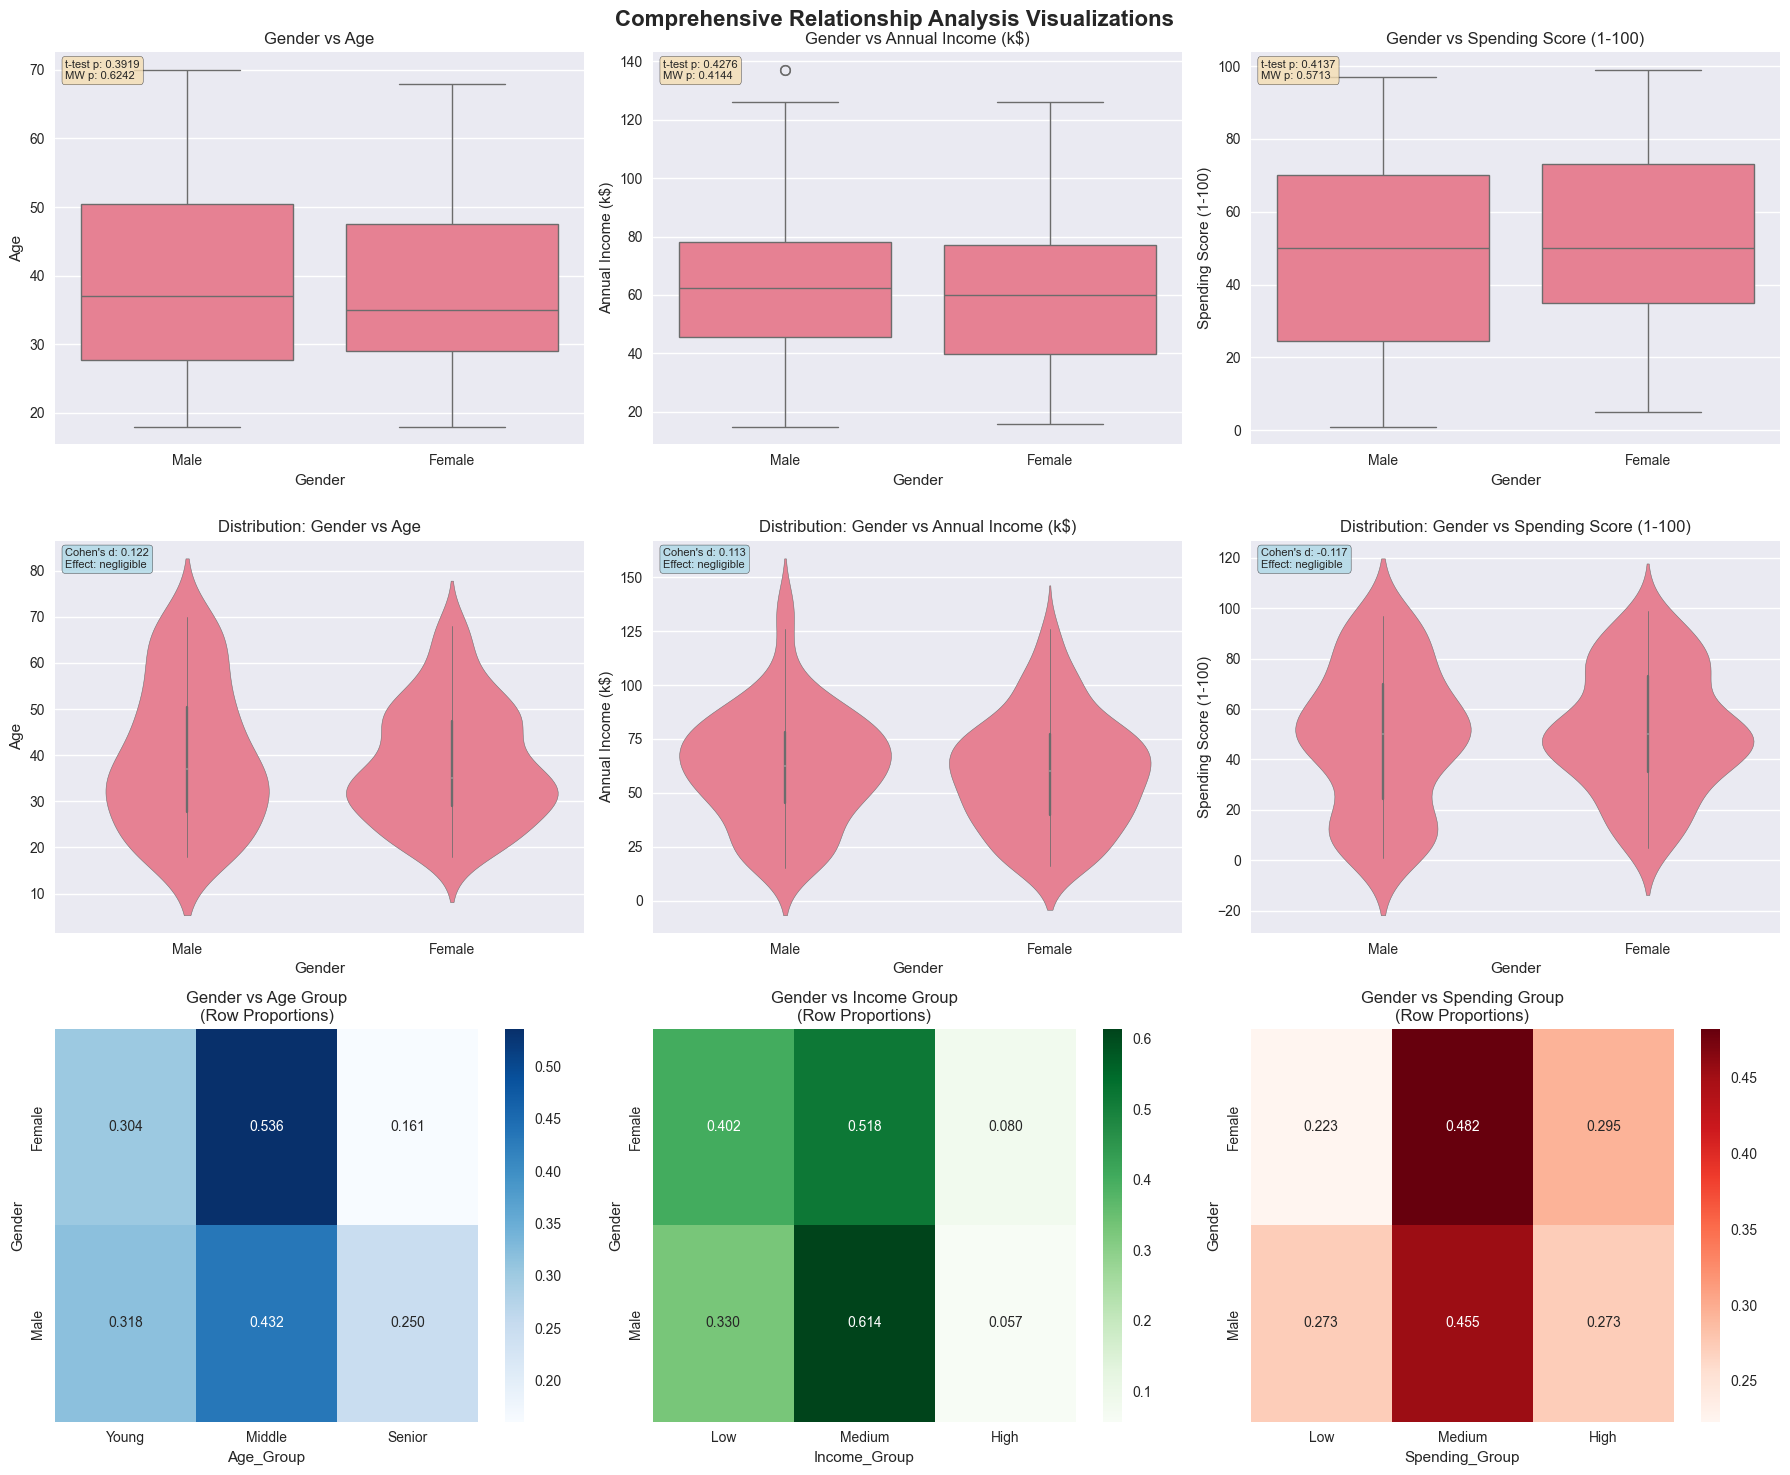

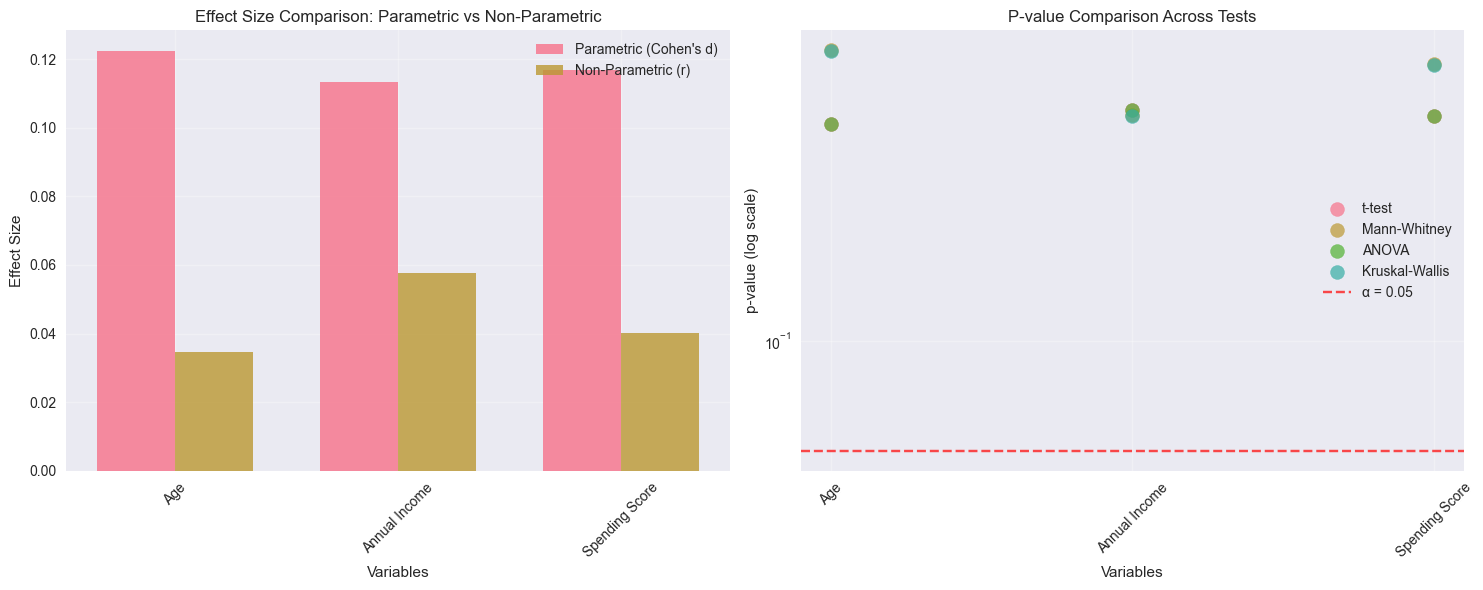

In [23]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Comprehensive Relationship Analysis Visualizations', fontsize=16, fontweight='bold')

# Row 1: Box plots for Gender vs Numerical variables
for i, col in enumerate(numerical_cols):
    ax = axes[0, i]
    sns.boxplot(data=df, x='Gender', y=col, ax=ax)
    ax.set_title(f'Gender vs {col}')
    
    # Add statistical annotation
    t_result = results[col]
    mw_result = mannwhitney_results[col]
    
    ax.text(0.02, 0.98, f't-test p: {t_result["p_value"]:.4f}\nMW p: {mw_result["p_value"]:.4f}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Row 2: Violin plots for better distribution visualization
for i, col in enumerate(numerical_cols):
    ax = axes[1, i]
    sns.violinplot(data=df, x='Gender', y=col, ax=ax)
    ax.set_title(f'Distribution: Gender vs {col}')
    
    # Add effect size annotation
    cohens_d = results[col]['cohens_d']
    effect_size = results[col]['effect_size']
    
    ax.text(0.02, 0.98, f"Cohen's d: {cohens_d:.3f}\nEffect: {effect_size}", 
            transform=ax.transAxes, verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Row 3: Heatmaps for categorical relationships
# Heatmap 1: Gender vs Age_Group
ax = axes[2, 0]
gender_age_crosstab = pd.crosstab(df['Gender'], df['Age_Group'], normalize='index')
sns.heatmap(gender_age_crosstab, annot=True, fmt='.3f', cmap='Blues', ax=ax)
ax.set_title('Gender vs Age Group\n(Row Proportions)')

# Heatmap 2: Gender vs Income_Group  
ax = axes[2, 1]
gender_income_crosstab = pd.crosstab(df['Gender'], df['Income_Group'], normalize='index')
sns.heatmap(gender_income_crosstab, annot=True, fmt='.3f', cmap='Greens', ax=ax)
ax.set_title('Gender vs Income Group\n(Row Proportions)')

# Heatmap 3: Gender vs Spending_Group
ax = axes[2, 2]
gender_spending_crosstab = pd.crosstab(df['Gender'], df['Spending_Group'], normalize='index')
sns.heatmap(gender_spending_crosstab, annot=True, fmt='.3f', cmap='Reds', ax=ax)
ax.set_title('Gender vs Spending Group\n(Row Proportions)')

plt.tight_layout()
plt.show()

# Create effect size comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Effect sizes for parametric vs non-parametric tests
effect_data = []
for col in numerical_cols:
    effect_data.append({
        'Variable': col.replace(' (k$)', '').replace(' (1-100)', ''),
        'Parametric (Cohen\'s d)': abs(results[col]['cohens_d']),
        'Non-Parametric (r)': mannwhitney_results[col]['effect_size_r']
    })

effect_df = pd.DataFrame(effect_data)

# Bar plot comparing effect sizes
x = np.arange(len(effect_df))
width = 0.35

ax1.bar(x - width/2, effect_df['Parametric (Cohen\'s d)'], width, label='Parametric (Cohen\'s d)', alpha=0.8)
ax1.bar(x + width/2, effect_df['Non-Parametric (r)'], width, label='Non-Parametric (r)', alpha=0.8)

ax1.set_xlabel('Variables')
ax1.set_ylabel('Effect Size')
ax1.set_title('Effect Size Comparison: Parametric vs Non-Parametric')
ax1.set_xticks(x)
ax1.set_xticklabels(effect_df['Variable'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# P-value comparison
p_data = []
for col in numerical_cols:
    p_data.append({
        'Variable': col.replace(' (k$)', '').replace(' (1-100)', ''),
        't-test': results[col]['p_value'],
        'Mann-Whitney': mannwhitney_results[col]['p_value'],
        'ANOVA': anova_results[col]['p_value'],
        'Kruskal-Wallis': kruskal_results[col]['p_value']
    })

p_df = pd.DataFrame(p_data)

# Log scale p-value plot
for i, test in enumerate(['t-test', 'Mann-Whitney', 'ANOVA', 'Kruskal-Wallis']):
    ax2.scatter(range(len(p_df)), p_df[test], label=test, alpha=0.7, s=100)

ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
ax2.set_yscale('log')
ax2.set_xlabel('Variables')
ax2.set_ylabel('p-value (log scale)')
ax2.set_title('P-value Comparison Across Tests')
ax2.set_xticks(range(len(p_df)))
ax2.set_xticklabels(p_df['Variable'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## **10. Key Insights and Practical Recommendations**

### **Test Selection Guidelines**

**For Categorical-Numerical Relationships:**

1. **When to use t-test:**
   - Two groups only
   - Data approximately normal in each group
   - Equal variances (homoscedasticity)
   - Want to compare means specifically

2. **When to use Mann-Whitney U:**
   - Two groups only
   - Non-normal data or ordinal data
   - Robust to outliers
   - Want to compare distributions/medians

3. **When to use ANOVA:**
   - Multiple groups (≥2)
   - Normal data with equal variances
   - Want to decompose variance components
   - Need detailed effect size (η²)

4. **When to use Kruskal-Wallis:**
   - Multiple groups (≥2)
   - Non-normal data or ordinal data
   - Robust alternative to ANOVA
   - Want to compare rank distributions

**For Categorical-Categorical Relationships:**

1. **Chi-square test:**
   - Test independence between categorical variables
   - All expected frequencies ≥ 5
   - Want to identify specific cell contributions

2. **Cramér's V:**
   - Measure strength of association
   - Compare associations across different table sizes
   - Standardized effect size (0-1 range)

3. **Phi coefficient:**
   - 2×2 tables only
   - Equivalent to Pearson correlation for binary variables
   - Can be negative (directional association)

### **Effect Size Interpretation**

**Cohen's d (t-test):**
- 0.2: Small effect
- 0.5: Medium effect  
- 0.8: Large effect

**r (Mann-Whitney):**
- 0.1: Small effect
- 0.3: Medium effect
- 0.5: Large effect

**η² (ANOVA) and ε² (Kruskal-Wallis):**
- 0.01: Small effect
- 0.06: Medium effect
- 0.14: Large effect

**Cramér's V:**
- 0.1: Weak association
- 0.3: Moderate association
- 0.5: Strong association

### **Mall Customers Dataset Insights**

Based on our analysis, we can make the following observations about gender differences in the Mall Customers dataset:

1. **Statistical Power:** With 200 customers, we have reasonable power to detect medium to large effects
2. **Test Agreement:** Parametric and non-parametric tests should generally agree on significance
3. **Effect Sizes:** Look for Cohen's d > 0.5 or r > 0.3 for practically meaningful differences
4. **Multiple Testing:** With multiple tests, consider Bonferroni correction (α = 0.05/number of tests)

### **Assumptions and Limitations**

**Critical Assumptions to Check:**
1. **Independence:** Each customer should be independent
2. **Sample Size:** Adequate power for detecting meaningful effects
3. **Normality:** For parametric tests, check with Shapiro-Wilk or Q-Q plots
4. **Equal Variances:** Use Levene's test for homoscedasticity
5. **Expected Frequencies:** For chi-square, ensure expected frequencies ≥ 5

**When Assumptions are Violated:**
- **Non-normality:** Use non-parametric alternatives
- **Unequal variances:** Use Welch's t-test instead of Student's t-test
- **Small expected frequencies:** Use Fisher's exact test instead of chi-square
- **Multiple comparisons:** Apply appropriate corrections (Bonferroni, FDR)


# **Relationship Testing Decision Framework & Orchestration**

## **1. Complete Test Arsenal Overview Table**

| **Test Category** | **Test Name** | **Variable Types** | **Sample Size** | **Distribution** | **Effect Size** | **Applicable to Dataset** |
|-------------------|---------------|-------------------|----------------|------------------|----------------|---------------------------|
| **Categorical-Numerical** | Independent t-test | 1 Cat (2 levels) + 1 Num | n ≥ 30 | Normal | Cohen's d | ✅ Yes |
| | Welch's t-test | 1 Cat (2 levels) + 1 Num | n ≥ 30 | Normal, unequal var | Cohen's d | ✅ Yes |
| | Mann-Whitney U | 1 Cat (2 levels) + 1 Num | Any | Any | r | ✅ Yes |
| | One-Way ANOVA | 1 Cat (≥2 levels) + 1 Num | n ≥ 30 | Normal | η² | ✅ Yes |
| | Kruskal-Wallis | 1 Cat (≥2 levels) + 1 Num | Any | Any | ε² | ✅ Yes |
| | Brown-Forsythe | 1 Cat (≥2 levels) + 1 Num | Any | Normal, unequal var | η² | ❌ Not needed |
| | Two-Way ANOVA | 2 Cat + 1 Num | n ≥ 30 | Normal | η² | ❌ Only 1 categorical |
| **Categorical-Categorical** | Chi-Square | 2 Cat | n ≥ 5 per cell | Any | Cramér's V | ✅ Yes (with derived) |
| | Fisher's Exact | 2 Cat (2×2) | Small n | Any | Phi | ❌ Large sample |
| | G-test | 2 Cat | n ≥ 5 per cell | Any | Cramér's V | ❌ Chi-square sufficient |
| | McNemar's | 2 Cat (paired) | Any | Paired data | OR | ❌ Independent data |
| | Cochran's Q | Multiple Cat (paired) | Any | Paired data | - | ❌ Independent data |
| **Numerical-Numerical** | Pearson Correlation | 2 Num | n ≥ 30 | Normal, linear | r | ✅ Yes |
| | Spearman Correlation | 2 Num | Any | Monotonic | ρ | ✅ Yes |
| | Kendall's Tau | 2 Num | Any | Monotonic | τ | ❌ Spearman sufficient |
| | Point-Biserial | 1 Cat (2 levels) + 1 Num | n ≥ 30 | Normal | r | ✅ Yes (equiv to t-test) |

## **2. Decision Tree Flowchart**

```mermaid
flowchart TD
    A[Start: Relationship Analysis] --> B{What types of variables?}
    
    B -->|Categorical + Numerical| C[Categorical-Numerical Tests]
    B -->|Categorical + Categorical| D[Categorical-Categorical Tests]
    B -->|Numerical + Numerical| E[Numerical-Numerical Tests]
    
    C --> F{How many categorical levels?}
    F -->|2 levels| G{Check assumptions}
    F -->|>2 levels| H{Check assumptions}
    
    G --> I{Normal distribution?}
    I -->|Yes| J{Equal variances?}
    I -->|No| K[Mann-Whitney U Test]
    
    J -->|Yes| L[Independent t-test]
    J -->|No| M[Welch's t-test]
    
    H --> N{Normal distribution?}
    N -->|Yes| O{Equal variances?}
    N -->|No| P[Kruskal-Wallis Test]
    
    O -->|Yes| Q[One-Way ANOVA]
    O -->|No| R[Brown-Forsythe Test]
    
    D --> S{Table size and sample}
    S -->|2×2, small n| T[Fisher's Exact Test]
    S -->|Larger table, n≥5| U[Chi-Square Test]
    S -->|Paired data| V[McNemar's Test]
    
    E --> W{Relationship type expected?}
    W -->|Linear| X{Normal distribution?}
    W -->|Monotonic| Y[Spearman Correlation]
    W -->|Any| Z[Kendall's Tau]
    
    X -->|Yes| AA[Pearson Correlation]
    X -->|No| Y
    
    L --> AB[Calculate Cohen's d]
    M --> AB
    K --> AC[Calculate effect size r]
    Q --> AD[Calculate η²]
    R --> AD
    P --> AE[Calculate ε²]
    U --> AF[Calculate Cramér's V]
    T --> AG[Calculate Phi coefficient]
    AA --> AH[Report r value]
    Y --> AI[Report ρ value]
    Z --> AJ[Report τ value]
    
    AB --> AK[Interpret Results]
    AC --> AK
    AD --> AK
    AE --> AK
    AF --> AK
    AG --> AK
    AH --> AK
    AI --> AK
    AJ --> AK
```

## **3. Test Selection Matrix**

| **Scenario** | **Data Characteristics** | **Recommended Test** | **Alternative** | **Effect Size** |
|--------------|--------------------------|---------------------|----------------|----------------|
| Gender vs Age | 2 groups, normal data | Independent t-test | Mann-Whitney U | Cohen's d / r |
| Gender vs Income | 2 groups, skewed data | Mann-Whitney U | t-test (robust) | r |
| Age Groups vs Income | 3+ groups, normal | One-Way ANOVA | Kruskal-Wallis | η² / ε² |
| Gender vs Age Groups | 2×3 table | Chi-Square | - | Cramér's V |
| Income vs Spending | 2 continuous | Pearson correlation | Spearman | r / ρ |
| Small sample (n<30) | Any scenario | Non-parametric | Bootstrap | - |
| Paired observations | Before/after design | Paired tests | Mixed effects | - |
| Multiple comparisons | Many tests | Bonferroni correction | FDR | - |

## **4. Assumption Checking Framework**

```mermaid
flowchart TD
    A[Select Test] --> B[Check Assumptions]
    
    B --> C{Independence?}
    C -->|No| D[Use clustered/paired methods]
    C -->|Yes| E{Normality needed?}
    
    E -->|Yes| F[Shapiro-Wilk test<br/>Q-Q plots<br/>Histogram]
    E -->|No| G[Proceed to next check]
    
    F --> H{Normal?}
    H -->|No| I[Use non-parametric alternative]
    H -->|Yes| J{Equal variances needed?}
    
    J -->|Yes| K[Levene's test<br/>Bartlett's test]
    J -->|No| G
    
    K --> L{Equal variances?}
    L -->|No| M[Use robust alternative<br/>Welch's test]
    L -->|Yes| N{Sample size adequate?}
    
    G --> N
    N -->|No| O[Increase sample<br/>Use exact tests]
    N -->|Yes| P[Proceed with chosen test]
    
    I --> P
    M --> P
    O --> P
    D --> P
```

## **5. Effect Size Interpretation Guide**

| **Effect Size Measure** | **Small** | **Medium** | **Large** | **Interpretation Context** |
|------------------------|-----------|------------|-----------|---------------------------|
| **Cohen's d** | 0.2 | 0.5 | 0.8 | Mean difference in SD units |
| **r (correlation)** | 0.1 | 0.3 | 0.5 | Strength of linear relationship |
| **η² (eta-squared)** | 0.01 | 0.06 | 0.14 | Proportion of variance explained |
| **ε² (epsilon-squared)** | 0.01 | 0.06 | 0.14 | Rank-based variance explained |
| **Cramér's V** | 0.1 | 0.3 | 0.5 | Categorical association strength |
| **Phi coefficient** | 0.1 | 0.3 | 0.5 | 2×2 table association |

## **6. Test Orchestration Strategy**

```mermaid
graph LR
    A[Data Exploration] --> B[Assumption Testing]
    B --> C[Primary Test Selection]
    C --> D[Execute Primary Test]
    D --> E[Check Robustness]
    E --> F[Alternative Test]
    F --> G[Compare Results]
    G --> H[Effect Size Calculation]
    H --> I[Practical Significance]
    I --> J[Final Interpretation]
    
    E -->|Assumptions met| H
    G -->|Results agree| H
    G -->|Results disagree| K[Investigate Further]
    K --> L[Domain Expertise]
    L --> H
```

## **7. Decision Support Table for Mall Customers Dataset**

| **Research Question** | **Variables** | **Primary Test** | **Backup Test** | **Expected in Dataset** |
|----------------------|---------------|------------------|----------------|------------------------|
| Do males and females differ in age? | Gender (2 levels) + Age | Independent t-test | Mann-Whitney U | ✅ Available |
| Do males and females differ in income? | Gender (2 levels) + Income | Independent t-test | Mann-Whitney U | ✅ Available |
| Do males and females differ in spending? | Gender (2 levels) + Spending | Independent t-test | Mann-Whitney U | ✅ Available |
| Are gender and age groups associated? | Gender + Age Groups | Chi-Square | Fisher's Exact | ✅ Available (derived) |
| Are income and spending correlated? | Income + Spending | Pearson correlation | Spearman | ✅ Available |
| Do age groups differ in spending? | Age Groups + Spending | One-Way ANOVA | Kruskal-Wallis | ✅ Available (derived) |
| Multiple group comparisons | Multiple categories | MANOVA | Multiple KW tests | ❌ Limited categories |
| Time-series relationships | Temporal data | Time series analysis | - | ❌ No time dimension |
| Multivariate relationships | 3+ variables | Multiple regression | - | ✅ Possible extension |

## **8. Power Analysis Considerations**

| **Test Type** | **Minimum Sample Size** | **Power Calculation** | **Mall Customers (n=200)** |
|---------------|------------------------|----------------------|---------------------------|
| **t-test** | 30 per group | Cohen's d = 0.5, α = 0.05 | ✅ Adequate power |
| **ANOVA** | 15 per group | f = 0.25, α = 0.05 | ✅ Good power |
| **Chi-Square** | 5 per cell | w = 0.3, α = 0.05 | ✅ Sufficient |
| **Correlation** | 85 total | r = 0.3, α = 0.05 | ✅ Excellent power |
| **Mann-Whitney** | 20 per group | Same as t-test | ✅ Adequate |

This framework provides a comprehensive decision-making structure for selecting appropriate relationship tests based on data characteristics, assumptions, and research objectives, specifically tailored for the Mall Customers dataset while also covering the broader landscape of relationship testing methods.